# Time Series Forecasting: Walmart Dataset

By: Abhijith Senthilkumar (0244396724) & Vani Pant (0242319112)

In this notebook file, we have performed time series forecasting on the Walmart Dataset (both Part I and Part II).

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
#This is where we have stored the csv files:
#path = data/Supply Chain data 01

features = pd.read_csv('data/Supply Chain data 01/features.csv')
stores = pd.read_csv('data/Supply Chain data 01/stores.csv')
train = pd.read_csv('data/Supply Chain data 01/train.csv')
test = pd.read_csv('data/Supply Chain data 01/test.csv')

print("Features DataFrame:")
print(features.head())
print("\nStores DataFrame:")
print(stores.head())
print("\nTrain DataFrame:")
print(train.head())
print("\nTest DataFrame:")
print(test.head())

print("\nShapes of the DataFrames:")
print(f"Features: {features.shape}")
print(f"Stores: {stores.shape}")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

print("\nMissing values in each DataFrame:")
print(f"Features:\n{features.isnull().sum()}")
print(f"Stores:\n{stores.isnull().sum()}")
print(f"Train:\n{train.isnull().sum()}")
print(f"Test:\n{test.isnull().sum()}")  

print("\nData types of each DataFrame:")
print(f"Features:\n{features.dtypes}")
print(f"Stores:\n{stores.dtypes}")
print(f"Train:\n{train.dtypes}")
print(f"Test:\n{test.dtypes}")  

print("\nDescriptive statistics for each DataFrame:")
print(f"Features:\n{features.describe()}")
print(f"Stores:\n{stores.describe()}")
print(f"Train:\n{train.describe()}")
print(f"Test:\n{test.describe()}")

Features DataFrame:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  

Stores DataFrame:
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3 

## Part I - To compare forecasting at smallest unit level vs forecasting at aggregate level like store or department and then deaggregate to item level

The smallest level available is the Department level inside train.csv. So:
Unit level is (Store, Dept) time series of Weekly_Sales
Aggregate level is (Store) total weekly sales across all departments. 

So Method 1 is forecast each (Store, Dept) series directly and produce X_1 forecasts per department. 

Method 2 is:
1. Aggregate dept sales to Store Total (A_2).
2. Forecast Store Total sales (F_2) to produce Y
3. Splity Y back into dept forecasts (D_2) to produce X_2

And then compare X_1 vs X_2 at dept level to see which is better. 

For Part I, we only need (Store, Dept, Date, Weekly_Sales) from train.csv. 
features.csv is not needed because we're using TSE which is univariate. 

In [3]:
#parse Date to datetime format
train['Date'] = pd.to_datetime(train['Date'])

#sort by store, dept, date
train = train.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

#Confirm weekly frequency of the data
train_dates = train['Date'].drop_duplicates().sort_values()
date_diffs = train_dates.diff().dropna()
print("\nDate differences to confirm weekly frequency:")
print(date_diffs.value_counts())


Date differences to confirm weekly frequency:
Date
7 days    142
Name: count, dtype: int64


### Confirming the time step (weekly data)

We check the gaps between consecutive unique dates.

> - **What we observe:** every date is exactly **7 days** apart.  
> - **Why it matters:** this confirms the data is **weekly**, so “one seasonal year” is **52 weeks**.  
> - **Next step:** we can safely set the seasonal period to **m = 52** in Holt–Winters.


In [4]:
#Choosing the test window as last 4 weeks

#last 4 unique dates
last_4_dates = sorted(train_dates.tail(4).tolist())
print("\nLast 4 unique dates for test window:")
print(last_4_dates)


Last 4 unique dates for test window:
[Timestamp('2012-10-05 00:00:00'), Timestamp('2012-10-12 00:00:00'), Timestamp('2012-10-19 00:00:00'), Timestamp('2012-10-26 00:00:00')]


In [5]:
#First, we are picking just 3 stores and using all deparments for simplicity
#This will help in quicker experimentation to demonstrate unit vs aggregating

#we are selecting the stores with many departments and long history
#by computing number of deparments per store and pick the max

store_dept_counts = train.groupby('Store')['Dept'].nunique()
top_3_stores = store_dept_counts.sort_values(ascending=False).head(3).index.tolist()
print("\nTop 3 stores with most departments:")
print(top_3_stores)



Top 3 stores with most departments:
[19, 15, 13]


In [6]:
#Now we filter the train data for these stores
train_filtered = train[train['Store'].isin(top_3_stores)].reset_index(drop=True)
print(f"\nFiltered train data shape (only top 3 stores): {train_filtered.shape}")
#Verify the departments in these stores
for store in top_3_stores:
    depts = train_filtered[train_filtered['Store'] == store]['Dept'].nunique()
    print(f"Store {store} has {depts} unique departments.")
#Display the first few rows of the filtered train data
print("\nFiltered Train Data (first few rows):")
print(train_filtered.head())

#keep only (Store,Dept) pairs that have ALL last 4 test dates 
valid_pairs = (
    train_filtered[train_filtered["Date"].isin(last_4_dates)]
    .groupby(["Store", "Dept"])["Date"]
    .nunique()
)

valid_pairs = valid_pairs[valid_pairs == len(last_4_dates)].index

train_filtered = (
    train_filtered
    .set_index(["Store", "Dept"])
    .loc[valid_pairs]
    .reset_index()
)

print(f"\nAfter fairness filter, train_filtered shape: {train_filtered.shape}")

#Display the number of dates each department of each store has data for
dept_date_counts = train_filtered.groupby(['Store', 'Dept'])['Date'].nunique().reset_index()
dept_date_counts = dept_date_counts.rename(columns={'Date': 'Num_Dates'})
#print the counts in ascending order, from lowest to highest
dept_date_counts = dept_date_counts.sort_values(by='Num_Dates')
print("\nNumber of unique dates for each department in each store:")
print(dept_date_counts)


Filtered train data shape (only top 3 stores): (30523, 5)
Store 19 has 79 unique departments.
Store 15 has 79 unique departments.
Store 13 has 79 unique departments.

Filtered Train Data (first few rows):
   Store  Dept       Date  Weekly_Sales  IsHoliday
0     13     1 2010-02-05      46761.90      False
1     13     1 2010-02-12      78415.94       True
2     13     1 2010-02-19      44042.19      False
3     13     1 2010-02-26      31574.04      False
4     13     1 2010-03-05      34505.07      False

After fairness filter, train_filtered shape: (29799, 5)

Number of unique dates for each department in each store:
     Store  Dept  Num_Dates
177     19    39          9
136     15    94         96
120     15    60         99
88      15    18        110
157     19    18        110
..     ...   ...        ...
75      15     4        143
76      15     5        143
77      15     6        143
67      13    94        143
210     19    98        143

[211 rows x 3 columns]


### Selecting a small subset for fast, fair comparison

To keep computation reasonable, we focus on only **3 stores** with many departments.

> - **What we observe:** Stores **19, 15, 13** have the most departments (good coverage and richer series).  
> - **Fairness filter (important):** we keep only (Store, Dept) pairs that have **all 4 test dates** available.  
> - **Why it matters:** this ensures **both methods are evaluated on the exact same test weeks**, so the comparison is fair, and the dept-date count table shows that some departments have shorter history (example: Store 19, Dept 39 has only 9 weeks). Those short series are not reliable for yearly seasonality and will be handled later.


In [7]:
#Creating train and test splits based on last 4 weeks
train_set = train_filtered[~train_filtered['Date'].isin(last_4_dates)].reset_index(drop=True)
test_set = train_filtered[train_filtered['Date'].isin(last_4_dates)].reset_index(drop=True)
print(f"\nTrain set shape: {train_set.shape}")
print(f"Test set shape: {test_set.shape}")


Train set shape: (28955, 5)
Test set shape: (844, 5)


In [8]:
#Implementing helpers for evaluation metrics
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs(y_true - y_pred))

def wape(y_true, y_pred, eps=1e-12):
    """
    Weighted absolute percentage error.
    Safe when sums are 0 (eps avoids divide-by-zero).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.sum(np.abs(y_true))
    return (np.sum(np.abs(y_true - y_pred)) / max(denom, eps)) * 100

### Error metrics used in this project

We use three metrics to measure forecast quality:

> - **MAE:** average absolute error (easy to understand in sales units).  
> - **RMSE:** like MAE but penalizes large mistakes more (sensitive to big errors).  
> - **WAPE (%):** total absolute error divided by total actual sales 


In [9]:
def holt_winters_additive(y, alpha, beta, gamma, m):
    """
    Additive Holt-Winters (triple exponential smoothing).

    Returns:
      fitted: array (NaN for first m points, then 1-step-ahead fitted values)
      level, trend: final states
      seasonal: array length m (final seasonal states)
    """
    y = np.asarray(y, dtype=float)
    n = len(y)

    if n < m + 1:
        raise ValueError(f"Need at least m+1={m+1} observations, got n={n}.")

    #initialization 
    level = np.mean(y[:m])

    if n >= 2 * m:
        trend = (np.mean(y[m:2*m]) - np.mean(y[:m])) / m
    else:
        trend = 0.0

    seasonal = y[:m] - level  # additive seasonals

    fitted = np.full(n, np.nan)

    #update loop starts at t=m (first point where seasonality is defined cleanly)
    for t in range(m, n):
        idx = t % m

        # 1-step-ahead fitted value for y[t] using state up to t-1
        fitted[t] = level + trend + seasonal[idx]

        y_t = y[t]
        old_level = level
        old_trend = trend
        old_seasonal = seasonal[idx]

        # update states
        level = alpha * (y_t - old_seasonal) + (1 - alpha) * (old_level + old_trend)
        trend = beta * (level - old_level) + (1 - beta) * old_trend
        seasonal[idx] = gamma * (y_t - level) + (1 - gamma) * old_seasonal

    return fitted, level, trend, seasonal


### Holt–Winters (Additive) — what this function is doing

This function implements **triple exponential smoothing** with **additive seasonality**

> - We keep track of three parts of the time series:
>   - **Level:** the baseline sales level
>   - **Trend:** the direction of change (up/down) over time
>   - **Seasonality:** the repeating weekly pattern over a year (**m = 52**)
> - The model starts with a simple initialization (average of the first season).
> - From week `m` onward, it produces a **one-step-ahead fitted value** (what the model would predict for that week).
> - Then it updates the level, trend, and seasonal values using **alpha, beta, gamma**:
>   - **alpha:** how fast the level adapts
>   - **beta:** how fast the trend adapts
>   - **gamma:** how fast the seasonal pattern adapts
> - Output: it returns fitted values (inside training) and the final states needed for forecasting.


In [10]:
def hw_additive_rolling_forecast(y_train, y_test, m, alpha, beta, gamma):
    """
    Rolling horizon-1 forecasts:
    - Fit on y_train once -> state at end of training
    - For each test point:
        forecast next week
        then update state with actual
    """
    y_train = np.asarray(y_train, dtype=float)
    y_test = np.asarray(y_test, dtype=float)

    if len(y_train) < m + 1:
        raise ValueError(f"Need at least m+1={m+1} training observations, got {len(y_train)}.")

    _, level, trend, seasonal = holt_winters_additive(y_train, alpha, beta, gamma, m)

    n_train = len(y_train)
    y_pred = np.zeros(len(y_test), dtype=float)

    for k in range(len(y_test)):
        t = n_train + k
        idx = t % m

        # Forecast for time t (next step)
        y_pred[k] = level + trend + seasonal[idx]

        # Update with actual y_test[k]
        y_t = y_test[k]
        old_level = level
        old_trend = trend
        old_seasonal = seasonal[idx]

        level = alpha * (y_t - old_seasonal) + (1 - alpha) * (old_level + old_trend)
        trend = beta * (level - old_level) + (1 - beta) * old_trend
        seasonal[idx] = gamma * (y_t - level) + (1 - gamma) * old_seasonal

    return y_pred


### Rolling forecasts for the test period — what this function is doing

This function produces forecasts for the test weeks using a **rolling, one-step-ahead** process.

> - We fit Holt–Winters on the **training data** first.
> - For each test week:
>   1) forecast the next week  
>   2) then update the model using the **actual** observed value for that week  

In [11]:
#Grid search alpha, beta, gamma on training data using rolling 1-step MAE
#returns best params and best score
def hw_additive_grid_search(y_train, m, alpha_values, beta_values, gamma_values, val_len=8):
    if len(y_train) < m + val_len:
        raise ValueError(
            f"Need at least m+val_len={m+val_len} observations for tuning, got {len(y_train)}"
        )

    y_fit = y_train[:-val_len]
    y_val = y_train[-val_len:]

    best_mae = float('inf')
    best_params = (None, None, None)

    for alpha in alpha_values:
        for beta in beta_values:
            for gamma in gamma_values:
                try:
                    y_val_pred = hw_additive_rolling_forecast(y_fit, y_val, m, alpha, beta, gamma)
                    current_mae = mae(y_val, y_val_pred)
                except Exception:
                    continue

                if current_mae < best_mae:
                    best_mae = current_mae
                    best_params = (alpha, beta, gamma)

    return best_params, best_mae

### Parameter tuning (grid search) — what this function is doing

We choose the smoothing parameters **(alpha, beta, gamma)**.

> - We hold out the last `val_len = 8` points from the training series as a **validation** slice.
> - For each candidate (alpha, beta, gamma):
>   - we generate rolling one-step forecasts on the validation slice
>   - we compute **MAE** on that validation slice
> - The best parameters are the ones with the **lowest validation MAE**.

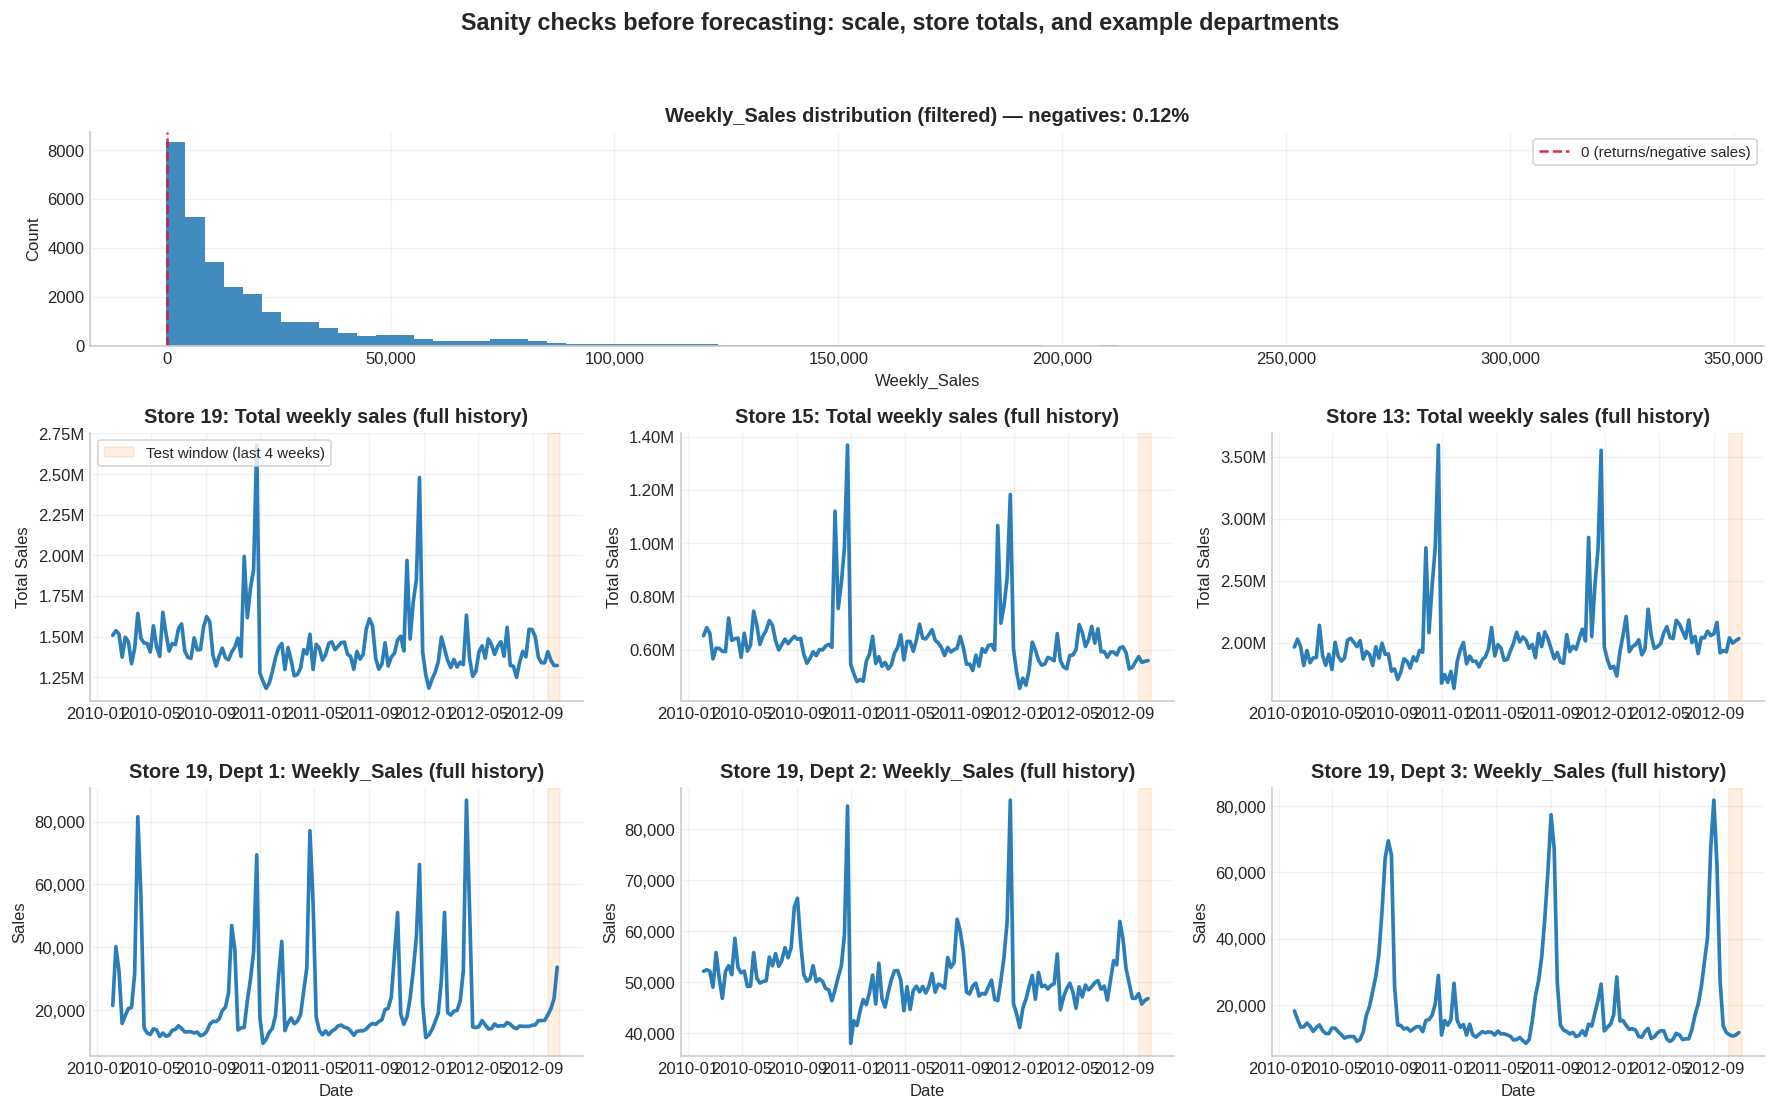

In [12]:
#Plotting
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
})

def fmt_thousands(x, pos):
    return f"{x:,.0f}"

def fmt_millions(x, pos):
    return f"{x/1e6:.2f}M"

#test window shading
test_start = pd.to_datetime(min(last_4_dates))
test_end = pd.to_datetime(max(last_4_dates)) + pd.Timedelta(days=7)  # cover full last week

#Store total series 
store_total_plot = (
    train_filtered.groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
    .sum()
    .rename(columns={"Weekly_Sales": "Store_Total_Sales"})
)
store_total_plot["Date"] = pd.to_datetime(store_total_plot["Date"])

#A few (Store,Dept) series examples 
example_store = top_3_stores[0]
example_depts = (
    train_filtered[train_filtered["Store"] == example_store]["Dept"]
    .drop_duplicates()
    .head(3)
    .tolist()
)

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, height_ratios=[1.0, 1.25, 1.25], hspace=0.35, wspace=0.20)

ax_hist = fig.add_subplot(gs[0, :])
ax_store = [fig.add_subplot(gs[1, i]) for i in range(3)]
ax_dept  = [fig.add_subplot(gs[2, i]) for i in range(3)]

fig.suptitle(
    "Sanity checks before forecasting: scale, store totals, and example departments",
    y=0.98, fontsize=14, fontweight="bold"
)

vals = train_filtered["Weekly_Sales"].values
neg_pct = 100.0 * np.mean(vals < 0)

ax_hist.hist(vals, bins=80, alpha=0.85, edgecolor="none")
ax_hist.axvline(0, linestyle="--", linewidth=1.5, color="crimson", alpha=0.9, label="0 (returns/negative sales)")
ax_hist.set_title(f"Weekly_Sales distribution (filtered) — negatives: {neg_pct:.2f}%")
ax_hist.set_xlabel("Weekly_Sales")
ax_hist.set_ylabel("Count")
ax_hist.xaxis.set_major_formatter(FuncFormatter(fmt_thousands))
ax_hist.legend(loc="upper right", frameon=True)

for i, store in enumerate(top_3_stores):
    g = store_total_plot[store_total_plot["Store"] == store].sort_values("Date")
    ax = ax_store[i]

    ax.plot(g["Date"], g["Store_Total_Sales"], linewidth=2.2, alpha=0.95)
    ax.axvspan(test_start, test_end, alpha=0.12, color="tab:orange", label="Test window (last 4 weeks)" if i == 0 else None)

    ax.set_title(f"Store {store}: Total weekly sales (full history)")
    ax.set_xlabel("")
    ax.set_ylabel("Total Sales")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_millions))
    ax.tick_params(axis="x", rotation=0)

ax_store[0].legend(loc="upper left", frameon=True)

for i, dept in enumerate(example_depts):
    g = train_filtered[
        (train_filtered["Store"] == example_store) & (train_filtered["Dept"] == dept)
    ].sort_values("Date")

    ax = ax_dept[i]
    ax.plot(g["Date"], g["Weekly_Sales"], linewidth=2.2, alpha=0.95)
    ax.axvspan(test_start, test_end, alpha=0.12, color="tab:orange")

    ax.set_title(f"Store {example_store}, Dept {dept}: Weekly_Sales (full history)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    ax.tick_params(axis="x", rotation=0)

plt.show()


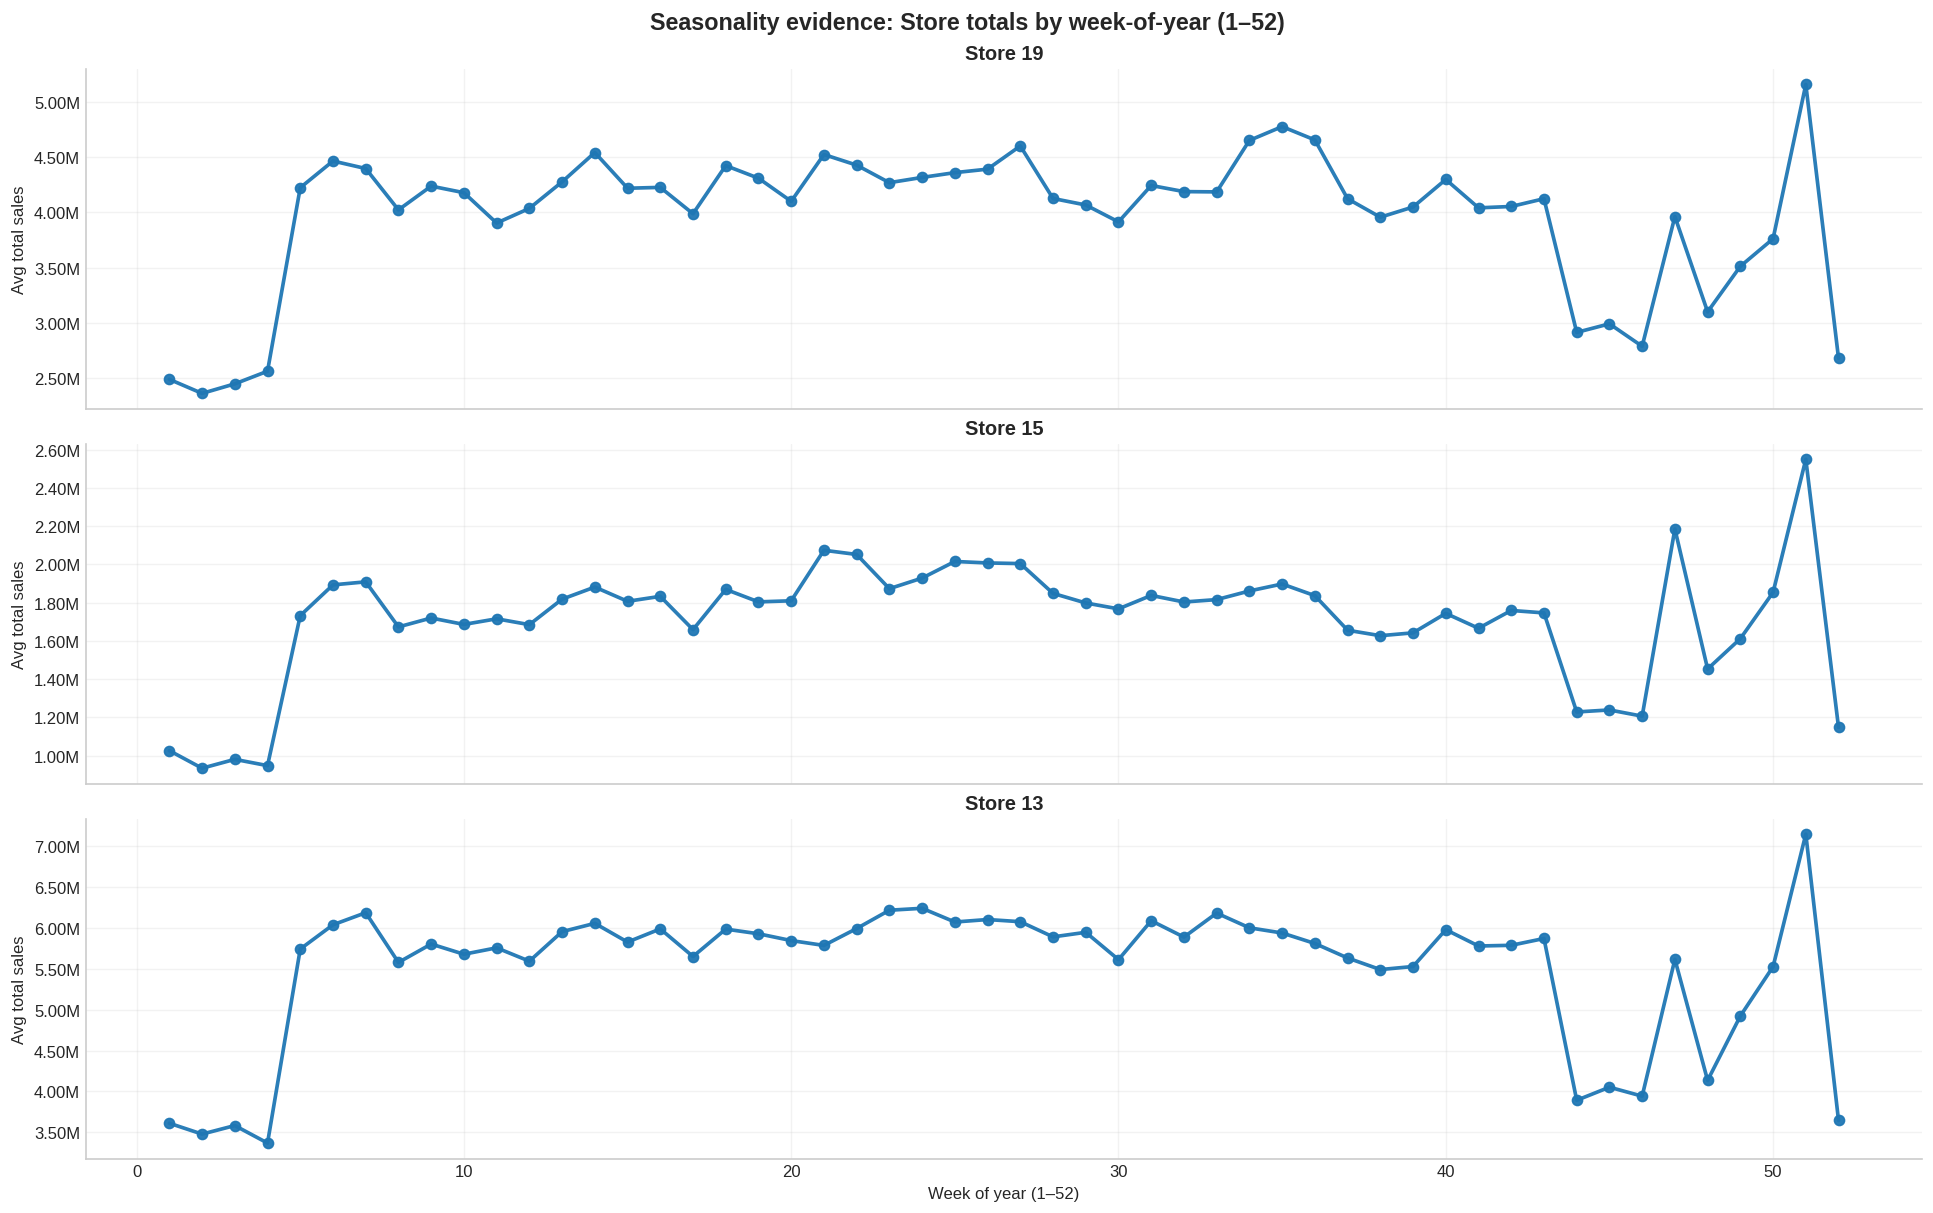

In [13]:
#seasonality evidence 
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
})

def fmt_millions(x, pos):
    return f"{x/1e6:.2f}M"

tmp = train_filtered.copy()
tmp["Date"] = pd.to_datetime(tmp["Date"])
tmp["woy"] = tmp["Date"].dt.isocalendar().week.astype(int)
tmp.loc[tmp["woy"] == 53, "woy"] = 52

store_woy = (
    tmp.groupby(["Store", "woy"], as_index=False)["Weekly_Sales"]
    .sum()
    .rename(columns={"Weekly_Sales": "Store_Total_Sales"})
)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10), sharex=True, constrained_layout=True)
fig.suptitle("Seasonality evidence: Store totals by week-of-year (1–52)", fontsize=14, fontweight="bold")

for ax, store in zip(axes, top_3_stores):
    g = store_woy[store_woy["Store"] == store].sort_values("woy")
    ax.plot(g["woy"], g["Store_Total_Sales"], marker="o", linewidth=2.2, alpha=0.95)
    ax.set_title(f"Store {store}")
    ax.set_ylabel("Avg total sales")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_millions))
    ax.grid(True, alpha=0.25)

axes[-1].set_xlabel("Week of year (1–52)")
plt.show()


### Method 1 - Forecast at item level directly

In [14]:
#Find count of dates for each dept in each store
dept_date_counts = train_filtered.groupby(['Store', 'Dept'])['Date'].nunique().reset_index()
dept_date_counts = dept_date_counts.rename(columns={'Date': 'Date_Count'})
print("\nDepartment date counts for each store:")
print(dept_date_counts.head())
#Display departments with less than 52 weeks of data
print(dept_date_counts[dept_date_counts['Date_Count'] < 52])


Department date counts for each store:
   Store  Dept  Date_Count
0     13     1         143
1     13     2         143
2     13     3         143
3     13     4         143
4     13     5         143
     Store  Dept  Date_Count
177     19    39           9


### Data coverage check at department level

Before forecasting each (Store, Dept) series, we check how many weekly observations each one has.

> **Very short series exist**
> - Store **19**, Dept **39** has only **9** weeks of data.  
> - **Why it matters:** with yearly seasonality (`m = 52`), very short series cannot support seasonal Holt–Winters reliably.
> - **What we do in code:** departments with too little training history are **skipped** during forecasting (`need at least 52 + val_len`).


In [15]:
# For each Dept in the chosen Store:
# we build y series (training and test)
# tune params (or reuse store-level params)
# rolling forecast -> X1
# Store results in a dataframe with columns: Dept, Date, y_true, yhat_x1

results = []

for store in top_3_stores:
    store_data = train_filtered[train_filtered['Store'] == store]
    depts = store_data['Dept'].unique()
    
    print(f"\nProcessing Store {store} with {len(depts)} departments.")
    
    for dept in depts:
        dept_data = store_data[store_data['Dept'] == dept].sort_values(by='Date')
        
        y = dept_data['Weekly_Sales'].values
        dates = dept_data['Date'].values
        
        # split into train and test based on last 4 dates
        train_mask = ~dept_data['Date'].isin(last_4_dates)
        test_mask = dept_data['Date'].isin(last_4_dates)
        
        y_train = y[train_mask]
        y_test = y[test_mask]
        test_dates = pd.to_datetime(dates[test_mask])

        if len(y_test) != len(last_4_dates):
            print(f"Skipping Store {store}, Dept {dept}: missing some of the last 4 test dates.")
            continue
        
        val_len = 8
        if len(y_train) < 52 + val_len:
            print(f"Skipping Store {store}, Dept {dept}: need at least {52+val_len} training points.")
            continue

        
        # Hyperparameter tuning
        alpha_values = [0.2, 0.4, 0.6, 0.8]
        beta_values = [0.1, 0.3, 0.5]
        gamma_values = [0.1, 0.3, 0.5]
        
        best_params, best_mae = hw_additive_grid_search(
            y_train, m=52,
            alpha_values=alpha_values,
            beta_values=beta_values,
            gamma_values=gamma_values,
            val_len=8
        )

        alpha_opt, beta_opt, gamma_opt = best_params
        
        print(f"Store {store}, Dept {dept}: Best Params - alpha: {alpha_opt}, beta: {beta_opt}, gamma: {gamma_opt} with MAE: {best_mae}")
        
        # Rolling forecast on test set
        y_pred = hw_additive_rolling_forecast(y_train, y_test, m=52, alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt)
        
        # Store results
        for i in range(len(y_test)):
            results.append({
                'Store': store,
                'Dept': dept,
                'Date': test_dates[i],
                'y_true': y_test[i],
                'yhat_x1': y_pred[i]
            })
#Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nForecasting results (first few rows):")
print(results_df.head())
results_df.groupby(['Store','Dept'])['Date'].nunique().value_counts()


Processing Store 19 with 70 departments.
Store 19, Dept 1: Best Params - alpha: 0.6, beta: 0.5, gamma: 0.5 with MAE: 562.7445937607006
Store 19, Dept 2: Best Params - alpha: 0.2, beta: 0.3, gamma: 0.5 with MAE: 1693.9935636076225
Store 19, Dept 3: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.5 with MAE: 3924.8359867916834
Store 19, Dept 4: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.3 with MAE: 1099.6917919207676
Store 19, Dept 5: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.5 with MAE: 2965.1366403260718
Store 19, Dept 6: Best Params - alpha: 0.8, beta: 0.3, gamma: 0.5 with MAE: 809.8762631108413
Store 19, Dept 7: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.5 with MAE: 2549.1396824581416
Store 19, Dept 8: Best Params - alpha: 0.8, beta: 0.5, gamma: 0.5 with MAE: 1333.1035168323497
Store 19, Dept 9: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.1 with MAE: 3290.332148475059
Store 19, Dept 10: Best Params - alpha: 0.2, beta: 0.5, gamma: 0.5 with MAE: 2710.2025519305876
Store 19, 

Date
4    210
Name: count, dtype: int64

### Method 1 output (X1) — what was produced

We build a separate Holt–Winters model for each (Store, Dept) series and forecasts the last 4 weeks.

> - **What we observe:** `results_df` contains:
>   - `y_true` = actual sales in the test weeks  
>   - `yhat_x1` = Method 1 forecast for those weeks  
> - The `value_counts()` result showing **4** means most (Store, Dept) pairs have forecasts for all **4 test dates**.


Overall metrics for X1:
MAE       1574.844174
RMSE      3128.047763
WAPE_%       8.407313
N          840.000000
dtype: float64

Metrics by store for X1:
               MAE         RMSE     WAPE_%      N
Store                                            
13     2000.854827  3924.959283   7.120455  288.0
19     1772.418253  3334.710811   9.054715  276.0
15      932.737239  1607.504885  11.496022  276.0


/tmp/ipykernel_1236244/2369994516.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_store_x1 = results_df.groupby("Store", group_keys=False).apply(lambda g: summarize_metrics(g, "yhat_x1"))


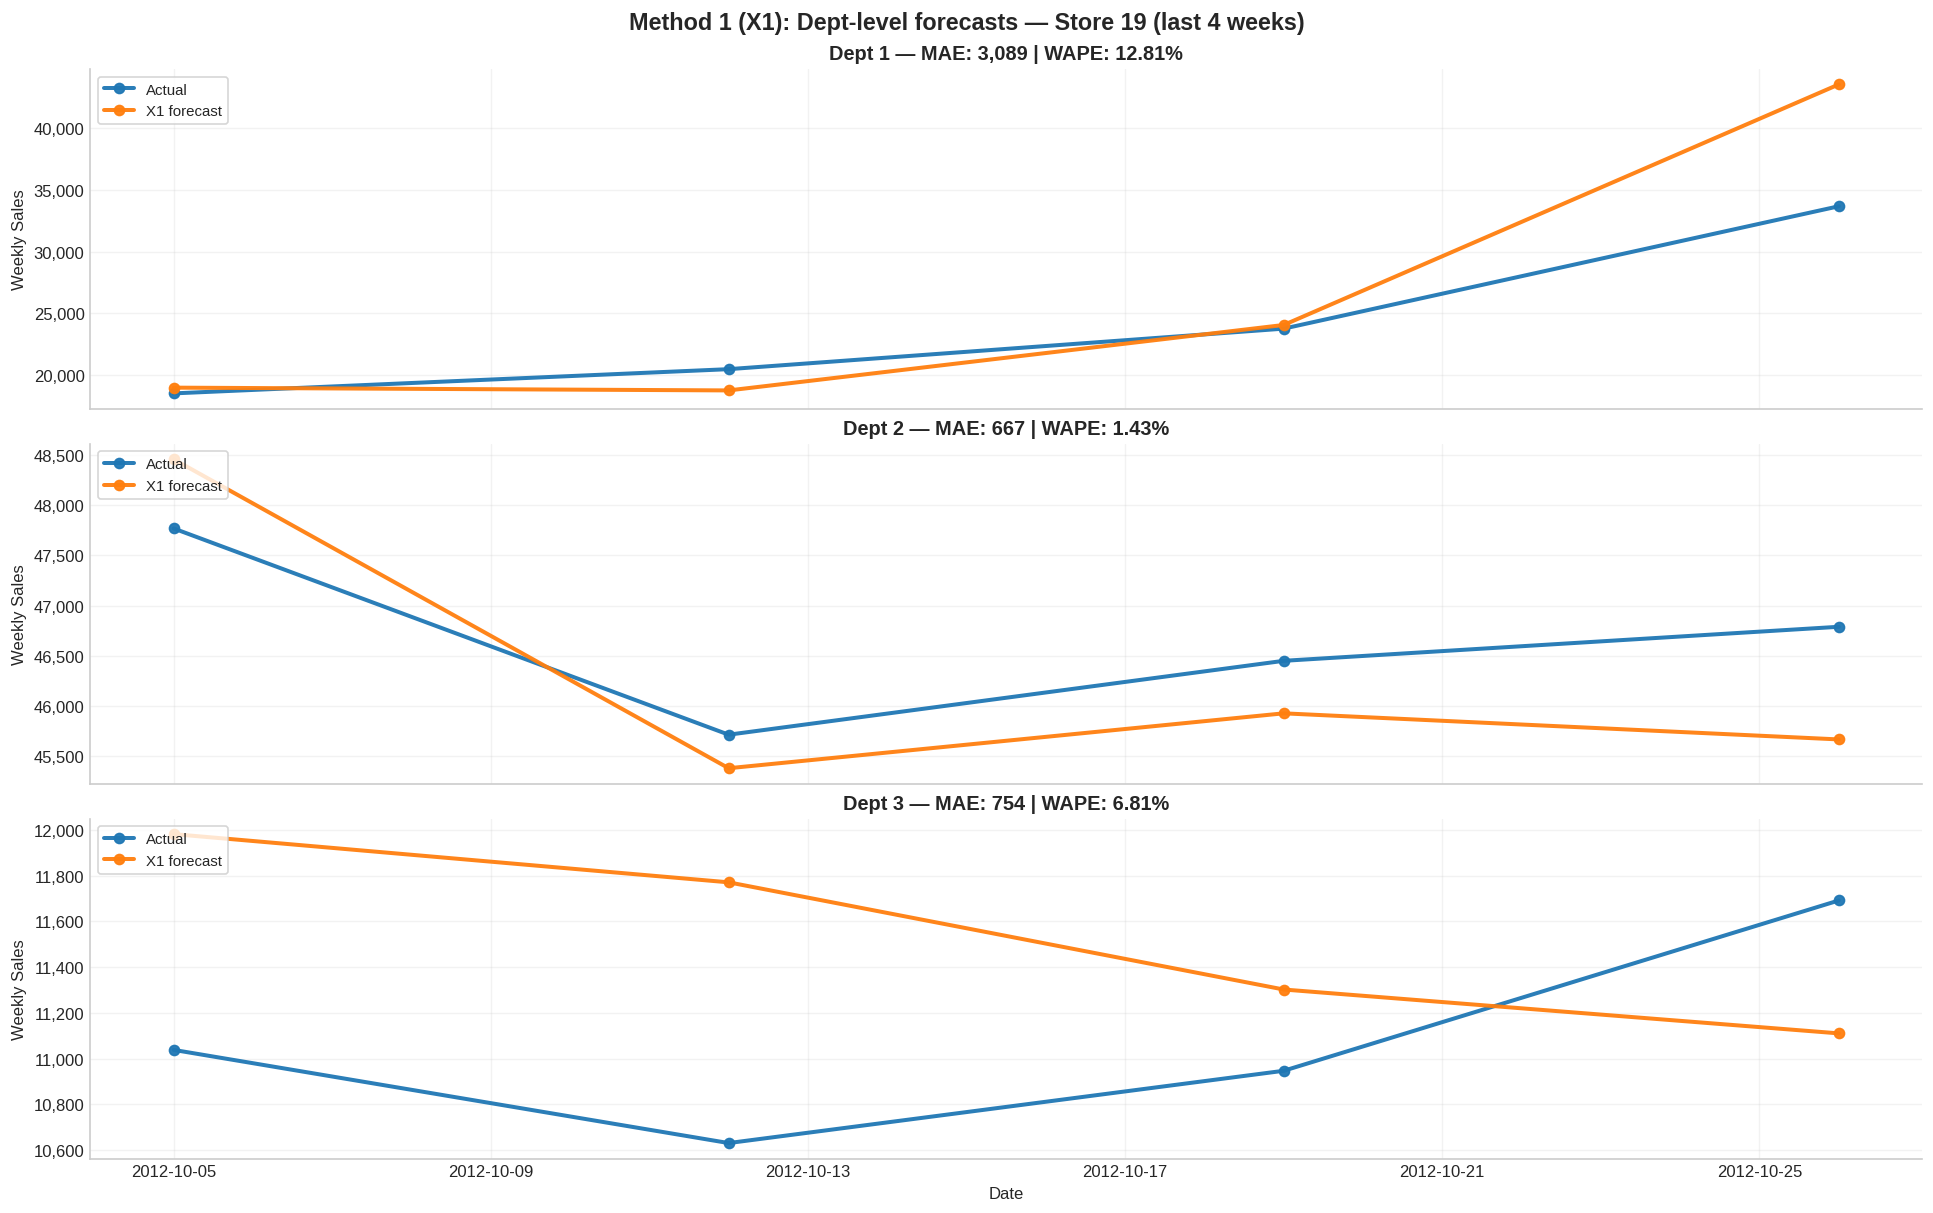

In [16]:
results_df["Date"] = pd.to_datetime(results_df["Date"])

def summarize_metrics(df, pred_col):
    y = df["y_true"].values
    yhat = df[pred_col].values
    return pd.Series({
        "MAE": mae(y, yhat),
        "RMSE": rmse(y, yhat),
        "WAPE_%": wape(y, yhat),
        "N": len(df)
    })

print("\nOverall metrics for X1:")
print(summarize_metrics(results_df, "yhat_x1"))

print("\nMetrics by store for X1:")
by_store_x1 = results_df.groupby("Store", group_keys=False).apply(lambda g: summarize_metrics(g, "yhat_x1"))
print(by_store_x1.sort_values("WAPE_%"))

#plotting a few examples
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
})

def fmt_thousands(x, pos):
    return f"{x:,.0f}"

results_df["Date"] = pd.to_datetime(results_df["Date"])

example = results_df[(results_df["Store"] == top_3_stores[0])].copy()
example_depts = example["Dept"].drop_duplicates().head(3).tolist()
example = example[example["Dept"].isin(example_depts)]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10), sharex=True, constrained_layout=True)
fig.suptitle(f"Method 1 (X1): Dept-level forecasts — Store {top_3_stores[0]} (last 4 weeks)", fontsize=14, fontweight="bold")

for ax, ((s, d), g) in zip(axes, example.groupby(["Store", "Dept"])):
    g = g.sort_values("Date")

    # KPI for the 4 test points
    dept_mae = mae(g["y_true"].values, g["yhat_x1"].values)
    dept_wape = wape(g["y_true"].values, g["yhat_x1"].values)

    ax.plot(g["Date"], g["y_true"], marker="o", linewidth=2.4, label="Actual", alpha=0.95)
    ax.plot(g["Date"], g["yhat_x1"], marker="o", linewidth=2.4, label="X1 forecast", alpha=0.95)

    ax.set_title(f"Dept {d} — MAE: {dept_mae:,.0f} | WAPE: {dept_wape:.2f}%")
    ax.set_ylabel("Weekly Sales")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    ax.legend(loc="upper left", frameon=True)

axes[-1].set_xlabel("Date")
for ax in axes:
    ax.tick_params(axis="x", rotation=0)

plt.show()

### Method 1 performance

Now we measure forecast errors across all department-level test points.

> - **Overall:** WAPE is about **8.41%**, meaning total absolute error is about 8.41% of total actual sales in the test data.  
> - **By store:** performance differs across stores:
>   - Store 13 has lower WAPE than Store 15 here, meaning it was easier to forecast at dept level.

### Method 2 - Aggregate, forecast, deaggregate

Overview:
1.  Aggregate: Store total weekly sales
2. Forecast: Forecast Store total (Y_hat) for the 4 test weeks
3. De-aggregate: Split each Y_hat back into Dept forecasts (X2) using seasonal shares


Store total dataframe head:
   Store       Date  Store_Total_Sales
0     13 2010-02-05         1967083.63
1     13 2010-02-12         2030748.07
2     13 2010-02-19         1970027.23
3     13 2010-02-26         1817772.89
4     13 2010-03-05         1939929.20


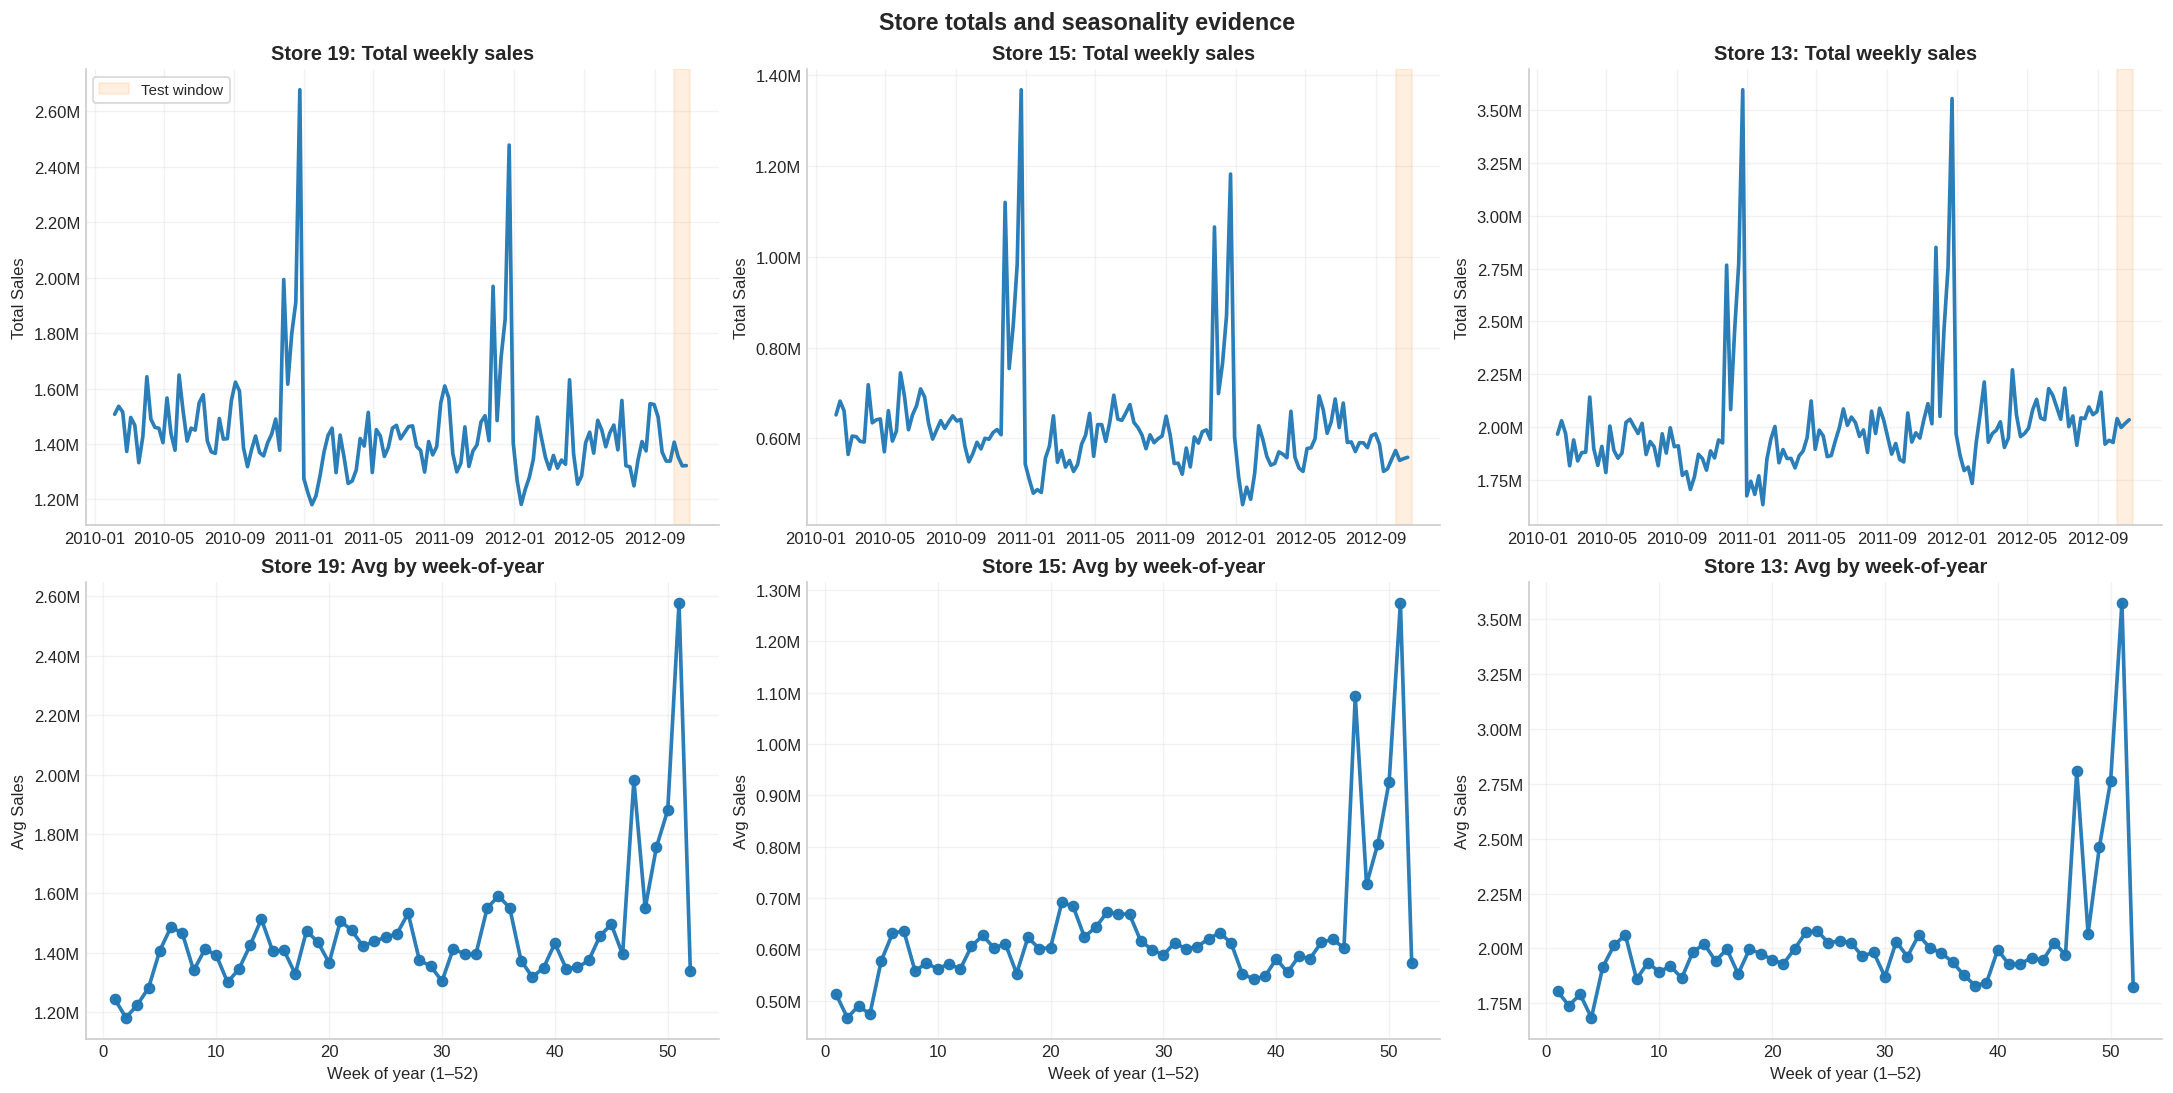

In [ ]:
#Build store total series (A2) and showing seasonality evidence 
store_total_df = (
    train_filtered
    .groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
    .sum()
    .rename(columns={"Weekly_Sales": "Store_Total_Sales"})
)

store_total_df["Date"] = pd.to_datetime(store_total_df["Date"])

print("Store total dataframe head:")
print(store_total_df.head())

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
})

def fmt_millions(x, pos):
    return f"{x/1e6:.2f}M"

store_total_df = (
    train_filtered
    .groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
    .sum()
    .rename(columns={"Weekly_Sales": "Store_Total_Sales"})
)
store_total_df["Date"] = pd.to_datetime(store_total_df["Date"])

test_start = pd.to_datetime(min(last_4_dates))
test_end = pd.to_datetime(max(last_4_dates)) + pd.Timedelta(days=7)

store_total_df["woy"] = store_total_df["Date"].dt.isocalendar().week.astype(int)
store_total_df.loc[store_total_df["woy"] == 53, "woy"] = 52

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9), constrained_layout=True)
fig.suptitle("Store totals and seasonality evidence", fontsize=14, fontweight="bold")

for i, store in enumerate(top_3_stores):
    ax = axes[0, i]
    g = store_total_df[store_total_df["Store"] == store].sort_values("Date")

    ax.plot(g["Date"], g["Store_Total_Sales"], linewidth=2.2, alpha=0.95)
    ax.axvspan(test_start, test_end, alpha=0.12, color="tab:orange", label="Test window" if i == 0 else None)

    ax.set_title(f"Store {store}: Total weekly sales")
    ax.set_ylabel("Total Sales")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_millions))
    ax.tick_params(axis="x", rotation=0)

axes[0, 0].legend(loc="upper left", frameon=True)

for i, store in enumerate(top_3_stores):
    ax = axes[1, i]
    g = store_total_df[store_total_df["Store"] == store].copy()
    seasonal_profile = g.groupby("woy")["Store_Total_Sales"].mean().reset_index()

    ax.plot(seasonal_profile["woy"], seasonal_profile["Store_Total_Sales"], marker="o", linewidth=2.2, alpha=0.95)
    ax.set_title(f"Store {store}: Avg by week-of-year")
    ax.set_xlabel("Week of year (1–52)")
    ax.set_ylabel("Avg Sales")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_millions))

plt.show()

### Method 2 setup (A2) — why we aggregate first

Here we create the store-total weekly sales series by summing all departments inside each store.

> - **Store totals are smoother:** aggregation reduces random department-level noise.
> - **Seasonality becomes clearer:** the week-of-year profile is usually easier to see at store level.
> - Method 2 is based on the idea that forecasting a cleaner (less noisy) aggregated series may improve accuracy, and then we split it back to departments.


Store 19 TOTAL: best (alpha,beta,gamma)=(0.2,0.3,0.5) val_MAE=38293.08087757148
Store 15 TOTAL: best (alpha,beta,gamma)=(0.4,0.1,0.5) val_MAE=12763.170171152444
Store 13 TOTAL: best (alpha,beta,gamma)=(0.2,0.1,0.1) val_MAE=66885.26625854042

Store total forecasts (Y_hat) head:
   Store       Date  y_total_true   y_total_hat
0     19 2012-10-05    1406698.10  1.418577e+06
1     19 2012-10-12    1352729.50  1.319877e+06
2     19 2012-10-19    1321102.35  1.349055e+06
3     19 2012-10-26    1322107.04  1.379632e+06
4     15 2012-10-05     573492.76  5.726073e+05

Store total forecast metrics (per store):
Store 19: MAE=32552.31, RMSE=36437.78, WAPE%=2.41, N=4
Store 15: MAE=11514.49, RMSE=17826.88, WAPE%=2.06, N=4
Store 13: MAE=37904.31, RMSE=38553.78, WAPE%=1.87, N=4


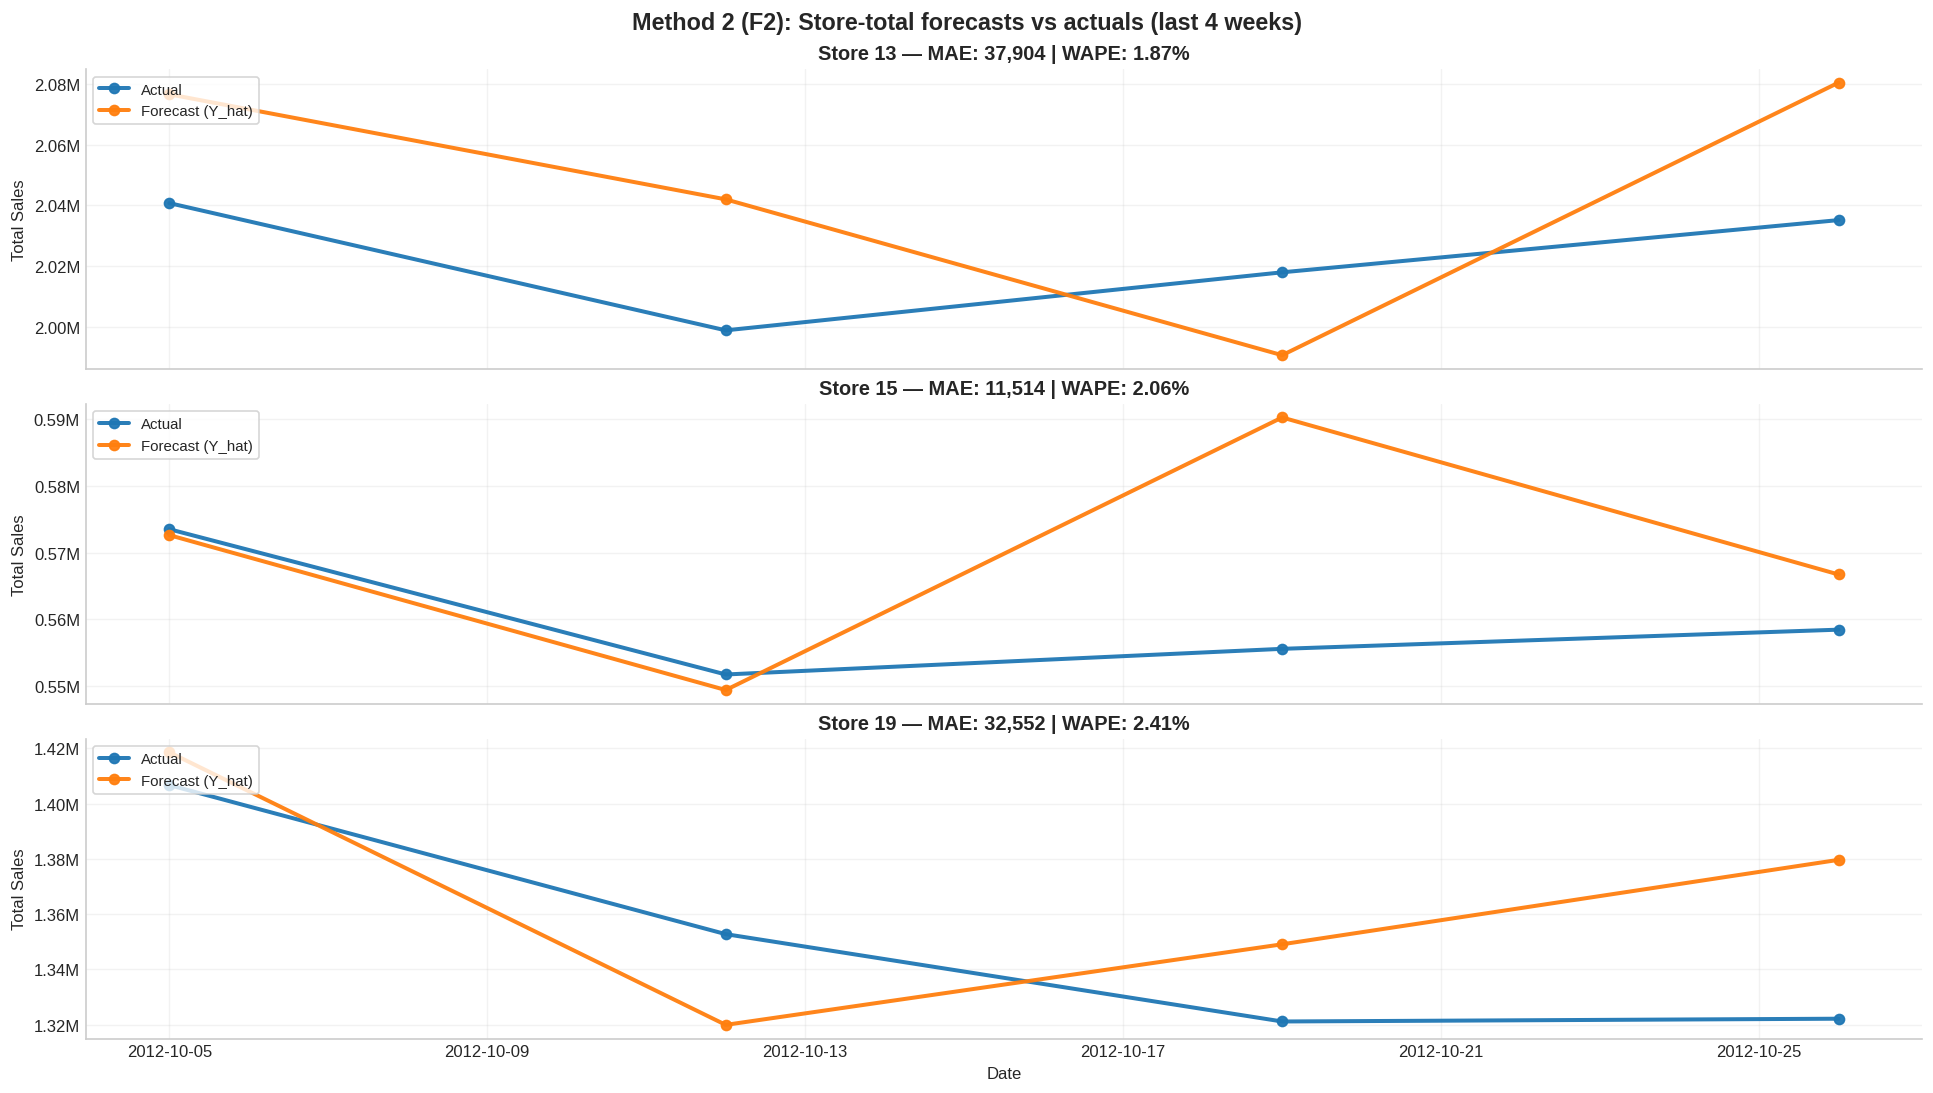

In [18]:
#Forecast Store Total (F2) to produce Y_hat

alpha_values = [0.2, 0.4, 0.6, 0.8]
beta_values  = [0.1, 0.3, 0.5]
gamma_values = [0.1, 0.3, 0.5]

store_forecasts = [] 

for store in top_3_stores:
    g = store_total_df[store_total_df["Store"] == store].sort_values("Date")

    y = g["Store_Total_Sales"].values
    dates = g["Date"].values

    train_mask = ~g["Date"].isin(last_4_dates)
    test_mask  =  g["Date"].isin(last_4_dates)

    y_train = y[train_mask]
    y_test  = y[test_mask]
    test_dates = pd.to_datetime(dates[test_mask])

    if len(y_test) != len(last_4_dates):
        print(f"Skipping Store {store} store-total forecast: missing some of the last 4 test dates.")
        continue

    val_len = 8
    if len(y_train) < 52 + val_len:
        print(f"Skipping Store {store} store-total forecast: need at least {52+val_len} training points.")
        continue

    best_params, best_mae = hw_additive_grid_search(
        y_train, m=52,
        alpha_values=alpha_values,
        beta_values=beta_values,
        gamma_values=gamma_values,
        val_len=val_len
    )

    alpha_opt, beta_opt, gamma_opt = best_params
    print(f"Store {store} TOTAL: best (alpha,beta,gamma)=({alpha_opt},{beta_opt},{gamma_opt}) val_MAE={best_mae}")

    yhat_total = hw_additive_rolling_forecast(
        y_train, y_test, m=52,
        alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt
    )

    for i in range(len(y_test)):
        store_forecasts.append({
            "Store": store,
            "Date": test_dates[i],
            "y_total_true": y_test[i],
            "y_total_hat": yhat_total[i]
        })

store_forecasts_df = pd.DataFrame(store_forecasts)
store_forecasts_df["Date"] = pd.to_datetime(store_forecasts_df["Date"])

print("\nStore total forecasts (Y_hat) head:")
print(store_forecasts_df.head())

print("\nStore total forecast metrics (per store):")
for store in store_forecasts_df["Store"].unique():
    g = store_forecasts_df[store_forecasts_df["Store"] == store]
    print(f"Store {store}: MAE={mae(g['y_total_true'], g['y_total_hat']):.2f}, "
          f"RMSE={rmse(g['y_total_true'], g['y_total_hat']):.2f}, "
          f"WAPE%={wape(g['y_total_true'], g['y_total_hat']):.2f}, N={len(g)}")

# Plot store total actual vs forecast (Y)
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
})

def fmt_millions(x, pos):
    return f"{x/1e6:.2f}M"

# Ensure datetime
store_forecasts_df["Date"] = pd.to_datetime(store_forecasts_df["Date"])

stores_in_forecast = sorted(store_forecasts_df["Store"].unique().tolist())
fig, axes = plt.subplots(nrows=len(stores_in_forecast), ncols=1, figsize=(16, 9), sharex=True, constrained_layout=True)

if len(stores_in_forecast) == 1:
    axes = [axes]

fig.suptitle("Method 2 (F2): Store-total forecasts vs actuals (last 4 weeks)", fontsize=14, fontweight="bold")

for ax, store in zip(axes, stores_in_forecast):
    g = store_forecasts_df[store_forecasts_df["Store"] == store].sort_values("Date")

    # KPI for this store (presentation-friendly)
    k_mae = mae(g["y_total_true"].values, g["y_total_hat"].values)
    k_wape = wape(g["y_total_true"].values, g["y_total_hat"].values)

    ax.plot(g["Date"], g["y_total_true"], marker="o", linewidth=2.4, label="Actual", alpha=0.95)
    ax.plot(g["Date"], g["y_total_hat"], marker="o", linewidth=2.4, label="Forecast (Y_hat)", alpha=0.95)

    ax.set_title(f"Store {store} — MAE: {k_mae:,.0f} | WAPE: {k_wape:.2f}%")
    ax.set_ylabel("Total Sales")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_millions))
    ax.legend(loc="upper left", frameon=True)

axes[-1].set_xlabel("Date")
for ax in axes:
    ax.tick_params(axis="x", rotation=0)

plt.show()


### Store-total forecasting results (Y_hat) — key observation

This is the forecasting step of Method 2: we forecast store totals for the last 4 weeks.

> **Store totals are forecasted very accurately**
> - WAPE is around **~2%** per store, which is much lower than the dept-level WAPE from Method 1.
> - **Meaning:** store totals are easier to forecast than individual departments because the aggregated series is smoother.
> - This shows the “aggregation advantage” clearly.

In [19]:
#De-aggregate (D2): seasonal shares -> X2 forecasts 

#training-only dataframe for share estimation
train_only = train_filtered[~train_filtered["Date"].isin(last_4_dates)].copy()
train_only["Date"] = pd.to_datetime(train_only["Date"])

#(1..52, then map 53->52)
train_only["woy"] = train_only["Date"].dt.isocalendar().week.astype(int)
train_only.loc[train_only["woy"] == 53, "woy"] = 52

#We will create X2 forecasts aligned to store_forecasts_df (which contains Y_hat)
x2_rows = []

for store in top_3_stores:
    sf = store_forecasts_df[store_forecasts_df["Store"] == store].copy()
    if sf.empty:
        print(f"Store {store}: no store-total forecasts available, skipping X2.")
        continue

    #departments to forecast
    store_depts = sorted(train_filtered[train_filtered["Store"] == store]["Dept"].unique().tolist())

    #build store total per (Date, woy) on training for share computation
    store_train = train_only[train_only["Store"] == store].copy()
    if store_train.empty:
        print(f"Store {store}: training-only data empty after split, skipping X2.")
        continue

    store_total_train = (
        store_train.groupby(["Date", "woy"], as_index=False)["Weekly_Sales"]
        .sum()
        .rename(columns={"Weekly_Sales": "store_total"})
    )

    #dept sales on training by (Dept, Date, woy)
    dept_train = (
        store_train.groupby(["Dept", "Date", "woy"], as_index=False)["Weekly_Sales"]
        .sum()
        .rename(columns={"Weekly_Sales": "dept_sales"})
    )

    #merge to compute share
    merged = dept_train.merge(store_total_train, on=["Date", "woy"], how="left")
    merged["share"] = np.where(
        merged["store_total"] != 0,
        merged["dept_sales"] / merged["store_total"],
        np.nan
    )

    #overall fallback share across all training weeks
    overall_dept_sum = merged.groupby("Dept")["dept_sales"].sum()
    overall_store_sum = store_total_train["store_total"].sum()
    if overall_store_sum == 0:
        #fallback is uniform distribution if store sum is 0 (rare edge case)
        overall_share = pd.Series(1.0 / len(store_depts), index=store_depts)
    else:
        overall_share = (overall_dept_sum / overall_store_sum).reindex(store_depts).fillna(0.0)

    #seasonal share: avg share per (Dept, woy)
    seasonal_share = (
        merged.groupby(["Dept", "woy"])["share"]
        .mean()
        .reset_index()
    )

    #matrix: rows=woy, cols=Dept
    share_mat = seasonal_share.pivot(index="woy", columns="Dept", values="share")

    #ensuring all depts exist as columns
    for d in store_depts:
        if d not in share_mat.columns:
            share_mat[d] = np.nan
    share_mat = share_mat[store_depts].sort_index()

    #for each test date, we pick woy, get share vector, renormalize, fallback if needed
    sf["woy"] = sf["Date"].dt.isocalendar().week.astype(int)
    sf.loc[sf["woy"] == 53, "woy"] = 52

    for _, row in sf.iterrows():
        date = row["Date"]
        woy = int(row["woy"])
        yhat_total = float(row["y_total_hat"])

        if woy in share_mat.index:
            w = share_mat.loc[woy].copy()
        else:
            w = pd.Series(np.nan, index=store_depts)

        #replace missing with 0 then check sum
        w = w.fillna(0.0)

        if w.sum() == 0:
            w = overall_share.copy()
        else:
            w = w / w.sum()

        #create dept-level forecasts
        for dept in store_depts:
            x2_rows.append({
                "Store": store,
                "Dept": dept,
                "Date": date,
                "yhat_x2": float(w.loc[dept] * yhat_total)
            })

x2_df = pd.DataFrame(x2_rows)
x2_df["Date"] = pd.to_datetime(x2_df["Date"])

print("\nX2 (de-aggregated) forecasts head:")
print(x2_df.head())

print("\nCoverage check (X2):")
print(x2_df.groupby(["Store", "Dept"])["Date"].nunique().value_counts())




X2 (de-aggregated) forecasts head:
   Store  Dept       Date       yhat_x2
0     19     1 2012-10-05  19679.529486
1     19     2 2012-10-05  50600.088669
2     19     3 2012-10-05  12161.277476
3     19     4 2012-10-05  32481.186566
4     19     5 2012-10-05  28715.405961

Coverage check (X2):
Date
4    211
Name: count, dtype: int64


### De-aggregation output (X2) — what this step is doing

Now we split each store-total forecast back into departments using “seasonal shares”.

> - For each store and each test date, we compute the **week-of-year**.
> - We estimate how each department usually contributes to total store sales in that same week-of-year (using training data only).
> - Then we multiply the store forecast (Y_hat) by those shares to create department forecasts (X2).
> - The coverage output showing **4** confirms most (Store, Dept) pairs get forecasts for all 4 test weeks.



Comparison dataframe head:
   Store  Dept       Date    y_true       yhat_x1       yhat_x2
0     19     1 2012-10-05  18526.20  18991.905854  19679.529486
1     19     1 2012-10-12  20489.20  18766.602711  20384.666417
2     19     1 2012-10-19  23772.27  24068.862156  24589.857782
3     19     1 2012-10-26  33686.67  43557.993143  41579.136331
4     19     2 2012-10-05  47767.58  48456.436558  50600.088669

Coverage check (comparison):
Date
4    210
Name: count, dtype: int64

Overall metrics: X1 vs X2
X1: MAE       1574.844174
RMSE      3128.047763
WAPE_%       8.407313
N          840.000000
dtype: float64
X2: MAE       1595.190924
RMSE      3036.817892
WAPE_%       8.515934
N          840.000000
dtype: float64

Metrics by store: X1 vs X2
   Store Method          MAE         RMSE     WAPE_%      N
0     13     X1  2000.854827  3924.959283   7.120455  288.0
1     13     X2  2052.280718  3730.725600   7.303465  288.0
2     15     X1   932.737239  1607.504885  11.496022  276.0
3     15 

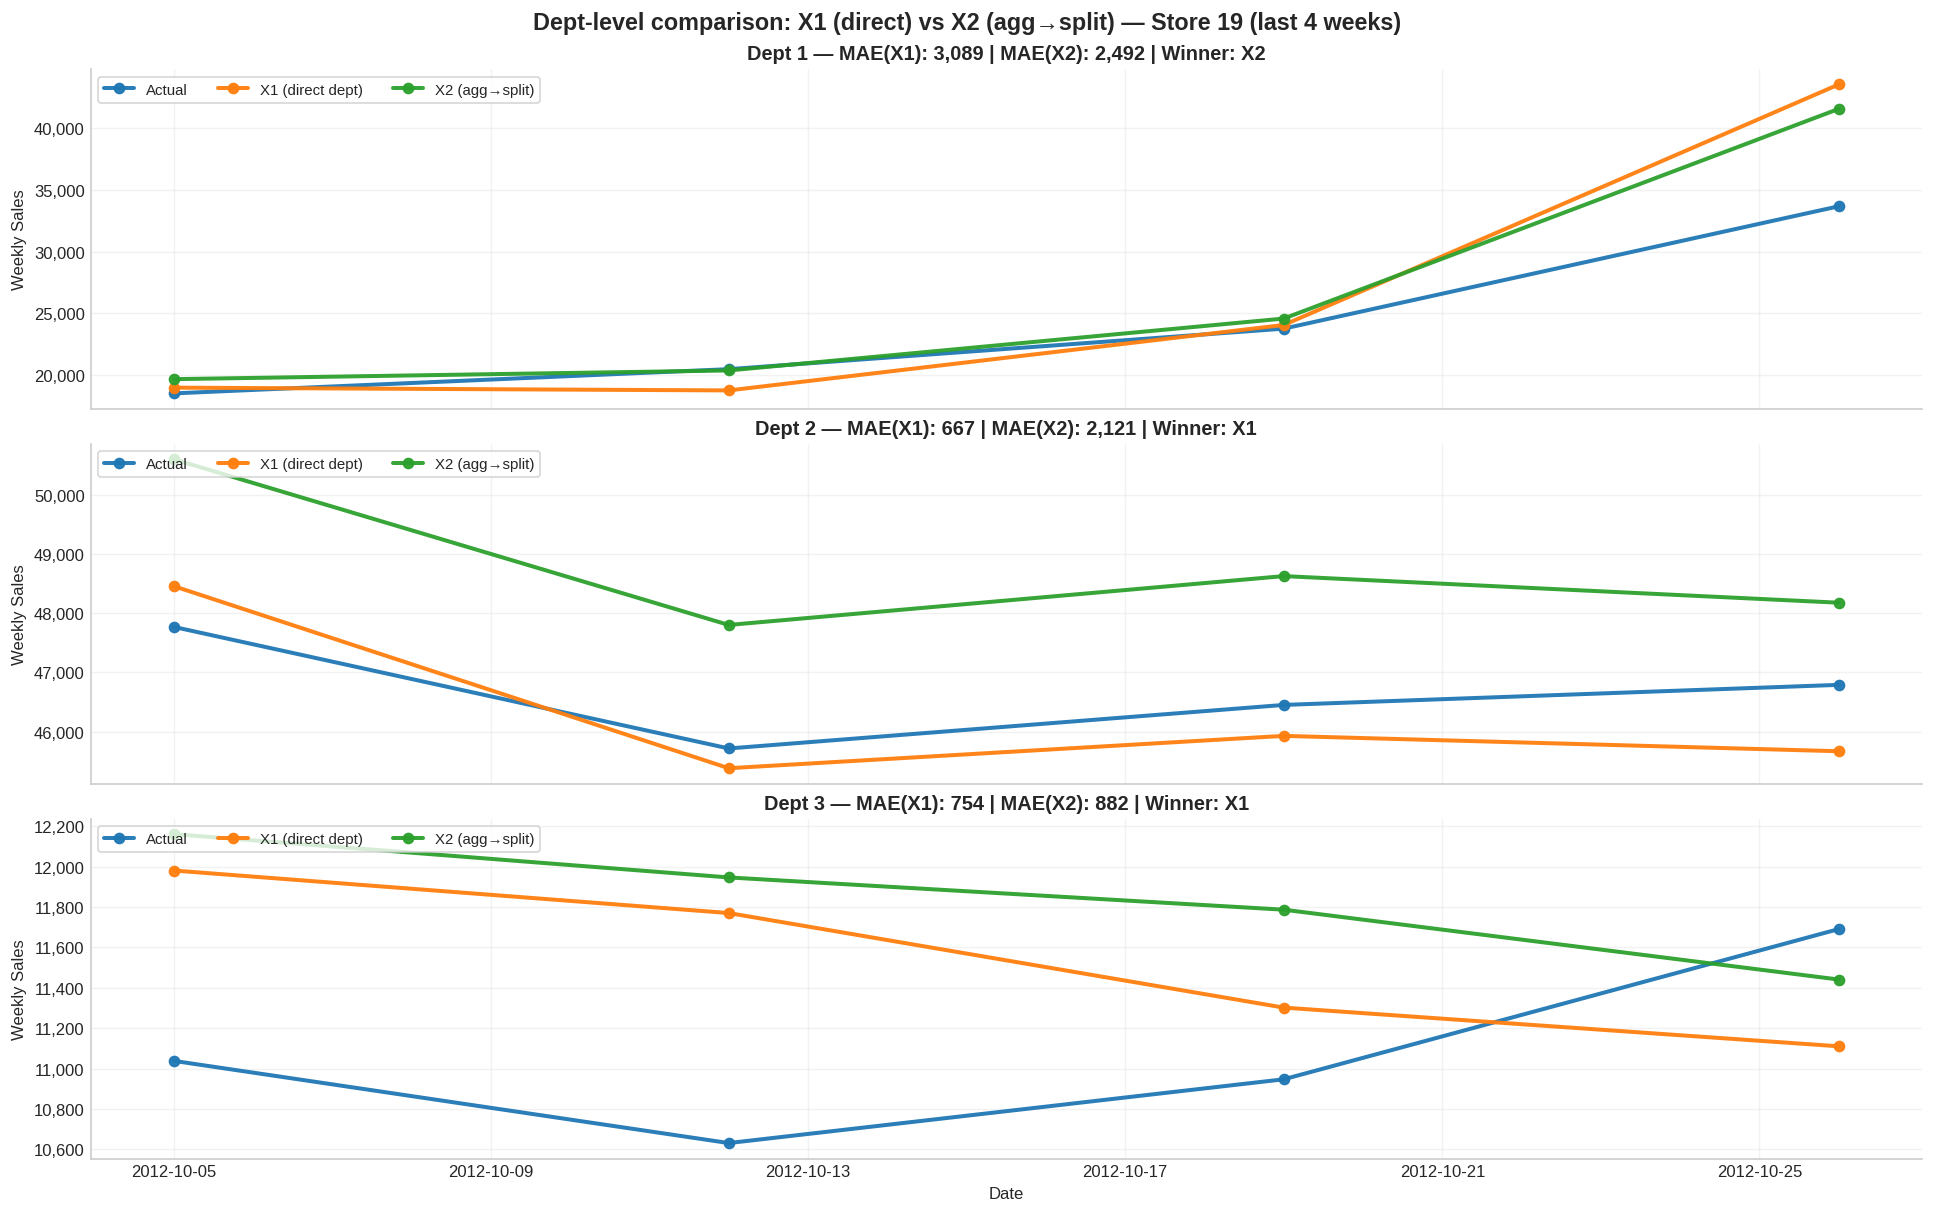

In [20]:
#Compare X1 vs X2 on the intersection of available forecasts

comparison_df = results_df.merge(
    x2_df, on=["Store", "Dept", "Date"], how="inner"
)

print("\nComparison dataframe head:")
print(comparison_df.head())

print("\nCoverage check (comparison):")
print(comparison_df.groupby(["Store", "Dept"])["Date"].nunique().value_counts())

print("\nOverall metrics: X1 vs X2")
print("X1:", summarize_metrics(comparison_df, "yhat_x1"))
print("X2:", summarize_metrics(comparison_df, "yhat_x2"))

print("\nMetrics by store: X1 vs X2")
by_store = []
for store in sorted(comparison_df["Store"].unique()):
    g = comparison_df[comparison_df["Store"] == store]
    m1 = summarize_metrics(g, "yhat_x1")
    m2 = summarize_metrics(g, "yhat_x2")
    out = pd.DataFrame([m1, m2], index=["X1", "X2"])
    out["Store"] = store
    by_store.append(out.reset_index().rename(columns={"index": "Method"}))

by_store_df = pd.concat(by_store, ignore_index=True)
print(by_store_df[["Store", "Method", "MAE", "RMSE", "WAPE_%", "N"]].sort_values(["Store", "Method"]))

#actual vs X1 vs X2 for few examples
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
})

def fmt_thousands(x, pos):
    return f"{x:,.0f}"

example = comparison_df[(comparison_df["Store"] == top_3_stores[0])].copy()
example_depts = example["Dept"].drop_duplicates().head(3).tolist()
example = example[example["Dept"].isin(example_depts)]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10), sharex=True, constrained_layout=True)
fig.suptitle(f"Dept-level comparison: X1 (direct) vs X2 (agg→split) — Store {top_3_stores[0]} (last 4 weeks)",
             fontsize=14, fontweight="bold")

for ax, ((s, d), g) in zip(axes, example.groupby(["Store", "Dept"])):
    g = g.sort_values("Date")

    #which method is better on MAE for this dept’s 4 test points?
    mae_x1 = mae(g["y_true"].values, g["yhat_x1"].values)
    mae_x2 = mae(g["y_true"].values, g["yhat_x2"].values)
    winner = "X1" if mae_x1 < mae_x2 else "X2"

    ax.plot(g["Date"], g["y_true"], marker="o", linewidth=2.4, label="Actual", alpha=0.95)
    ax.plot(g["Date"], g["yhat_x1"], marker="o", linewidth=2.4, label="X1 (direct dept)", alpha=0.95)
    ax.plot(g["Date"], g["yhat_x2"], marker="o", linewidth=2.4, label="X2 (agg→split)", alpha=0.95)

    ax.set_title(f"Dept {d} — MAE(X1): {mae_x1:,.0f} | MAE(X2): {mae_x2:,.0f} | Winner: {winner}")
    ax.set_ylabel("Weekly Sales")
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
    ax.legend(loc="upper left", ncol=3, frameon=True)

axes[-1].set_xlabel("Date")
for ax in axes:
    ax.tick_params(axis="x", rotation=0)

plt.show()

## Conclusion of Part I

We will first give you an overview of the methods again. We are only taking 3 stores (13, 15, 19) for this experiment to reduce computation time.

With method 1, for each (Store, Dept) series, we split into training (all except last 4 weeks) and test (last 4 weeks), then tune TSE parameters using a rolling 1-step validation (val length = 8) inside training, and fit on the full training data and produce rolling 1-step forecasts for the 4 test weeks, and collect the dept level forecasts (X1).

We implemented additive over multiplicative since weekly sales can be zero or negaive (returns).

With method 2, for each Store, we first aggregate weekly sales across all departments to get Store total weekly sales. Then we split into training (all except last 4 weeks) and test (last 4 weeks), then tune TSE parameters using a rolling 1-step validation (val length = 8) inside training, and fit on the full training data and produce rolling 1-step forecasts for the 4 test weeks to get Store total forecasts (Y_hat). Finally we split each Y_hat back into Dept forecasts (X2) using seasonal shares calculated from the training data.

### Results:

**Overall (840 dept-level test points)**
X₁ (Method 1):
* MAE 1574.84
* RMSE 3128.05
* WAPE 8.41%
X₂ (Method 2):
* MAE 1595.19
* RMSE 3036.82
* WAPE 8.52%

So Method 1 is slightly better in MAE and WAPE, while Method 2 is slightly better on RMSE (fewer very large errors), but its average % error is a bit worse. 

**By store (WAPE%)**
* Store 13: X₁ 7.12% vs X₂ 7.30% -> Method 1 better
* Store 19: X₁ 9.05% vs X₂ 9.16% -> Method 1 better
* Store 15: X₁ 11.50% vs X₂ 11.34% -> Method 2 better (small improvement)

So Method 1 is better at dept-level forecasting approach as it is better overall on WAPE and MAE. 
Method 2 produces excellent store-total forecasts, but the de-aggregation step adds errors at department level, making $X_2$ slightly worse overall. 
The key trade-off is that aggregation helps forecasting with smooth series and clear seasonality, but splitting forecasts back into departments can be imperfect when department shares change.

## Part II - To maximize chances of getting a rebate (store–supplier contract)

In Part II, we work with **one store** (weekly data) and assume we order **all items from one supplier**.

The contract rules are:

> * At the **beginning of each week**, we send the supplier a forecast for **2 weeks ahead** (**horizon-2**).
> * At the end of each month, the supplier computes a monthly KPI **ρₘ** using the weekly forecasts and actuals inside that month.
> * A month qualifies for rebate if **ρₘ is inside −X to +X**, where **X is chosen so that half of the last 12 months qualify**.

### Building store totals and checking the weekly calendar

We first aggregate sales to the **store level**:

> * **Why:** Part II is about forecasting the **total order quantity**, so we use store-total weekly sales.
> * We also confirm the dataset’s **week label day** (weekday), because month membership depends on the **first day of the week**.

### Selecting one store with strong seasonality

We choose one store that has:

> * Enough weeks of data  
> * Clear yearly seasonality  
> * Weekly spacing (exactly 7 days)

To measure seasonality strength, we compute the correlation between store total sales and sales **52 weeks earlier** (lag-52 correlation) for each store.

In [ ]:
train["Date"] = pd.to_datetime(train["Date"])

#Build store-total weekly sales series: A_t = sum_dept Weekly_Sales
store_total_all = (
    train.groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
         .sum()
         .rename(columns={"Weekly_Sales": "Store_Total_Sales"})
     .sort_values(["Store", "Date"])
     .reset_index(drop=True)
)

#Check the weekday of the Date labels 
weekday_counts = store_total_all["Date"].dt.day_name().value_counts()
print("Weekday distribution of Date labels (whole dataset):")
print(weekday_counts)

#For each store: compute a simple seasonality score using lag-52 correlation on totals
def lag52_corr(df_one_store):
    y = df_one_store["Store_Total_Sales"].values.astype(float)
    if len(y) < 120:  #strict minimum for a meaningful lag-52 correlation
        return np.nan
    y0 = y[52:]
    y1 = y[:-52]
    if np.std(y0) == 0 or np.std(y1) == 0:
        return np.nan
    return np.corrcoef(y0, y1)[0, 1]

scores = (
    store_total_all.groupby("Store")
    .apply(lag52_corr)
    .rename("lag52_corr")
    .reset_index()
)

scores["abs_lag52_corr"] = scores["lag52_corr"].abs()
scores = scores.sort_values("abs_lag52_corr", ascending=False).reset_index(drop=True)

print("\nTop 10 stores by |lag-52 correlation| (seasonality strength):")
print(scores.head(10))

#pick the best store deterministically - highest |lag-52 corr|
STORE_ID = int(scores.loc[0, "Store"])
print(f"\nChosen STORE_ID for Part II: {STORE_ID}")

#Extract chosen store series
s = store_total_all[store_total_all["Store"] == STORE_ID].copy()
s = s.sort_values("Date").reset_index(drop=True)

print("\nChosen store date range:")
print(s["Date"].min(), "to", s["Date"].max(), " | weeks:", len(s))

#check weekly spacing (must be 7 days)
diffs = s["Date"].diff().dropna()
print("\nDate diffs value counts (chosen store):")
print(diffs.value_counts().head(10))

if not (diffs == pd.Timedelta(days=7)).all():
    bad = s.loc[diffs != pd.Timedelta(days=7), ["Date"]].head(20)
    raise ValueError(
        "Found non-7-day gaps in the chosen store series. "
        "Paste the printed diffs and sample dates here.\n"
        f"{bad}"
    )

#define week_start for the contract month assignment:
#data labels a weekly point with a fixed weekday 
#first day of that week is (Date - 6 days)
s["week_start"] = s["Date"] - pd.Timedelta(days=6)

print("\nWeekday of Date label (chosen store):")
print(s["Date"].dt.day_name().value_counts())

print("\nWeekday of computed week_start (chosen store):")
print(s["week_start"].dt.day_name().value_counts())

#month membership uses the first day of the week
s["month_id"] = s["week_start"].dt.to_period("M")


Weekday distribution of Date labels (whole dataset):
Date
Friday    6435
Name: count, dtype: int64

Top 10 stores by |lag-52 correlation| (seasonality strength):
   Store  lag52_corr  abs_lag52_corr
0     41    0.949517        0.949517
1     16    0.940536        0.940536
2     32    0.940006        0.940006
3     10    0.935742        0.935742
4      8    0.935363        0.935363
5     15    0.934071        0.934071
6      7    0.928649        0.928649
7      4    0.925210        0.925210
8     12    0.923344        0.923344
9     34    0.920397        0.920397

Chosen STORE_ID for Part II: 41

Chosen store date range:
2010-02-05 00:00:00 to 2012-10-26 00:00:00  | weeks: 143

Date diffs value counts (chosen store):
Date
7 days    142
Name: count, dtype: int64

Weekday of Date label (chosen store):
Date
Friday    143
Name: count, dtype: int64

Weekday of computed week_start (chosen store):
week_start
Saturday    143
Name: count, dtype: int64


/tmp/ipykernel_1236244/1444281790.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lag52_corr)


### Output explanation

From the weekday check:

> * Weekly dates are labeled using a **fixed weekday** across the dataset.
> * This confirms a consistent weekly calendar and supports using **m = 52** weeks for yearly seasonality.

From the seasonality ranking, we select the store with the **highest |lag-52 correlation|** (strong yearly repetition).

From the spacing checks, the chosen store has **exactly 7-day gaps** between observations, so the weekly series is clean.

### Defining week start and month assignment

The contract says, a week belongs to a month if the **first day of that week** is inside the month.

Because the dataset labels each weekly point using a fixed weekday, we define `week_start = Date - 6 days`

Then we assign `month_id` based on `week_start` (this matches the contract rule).


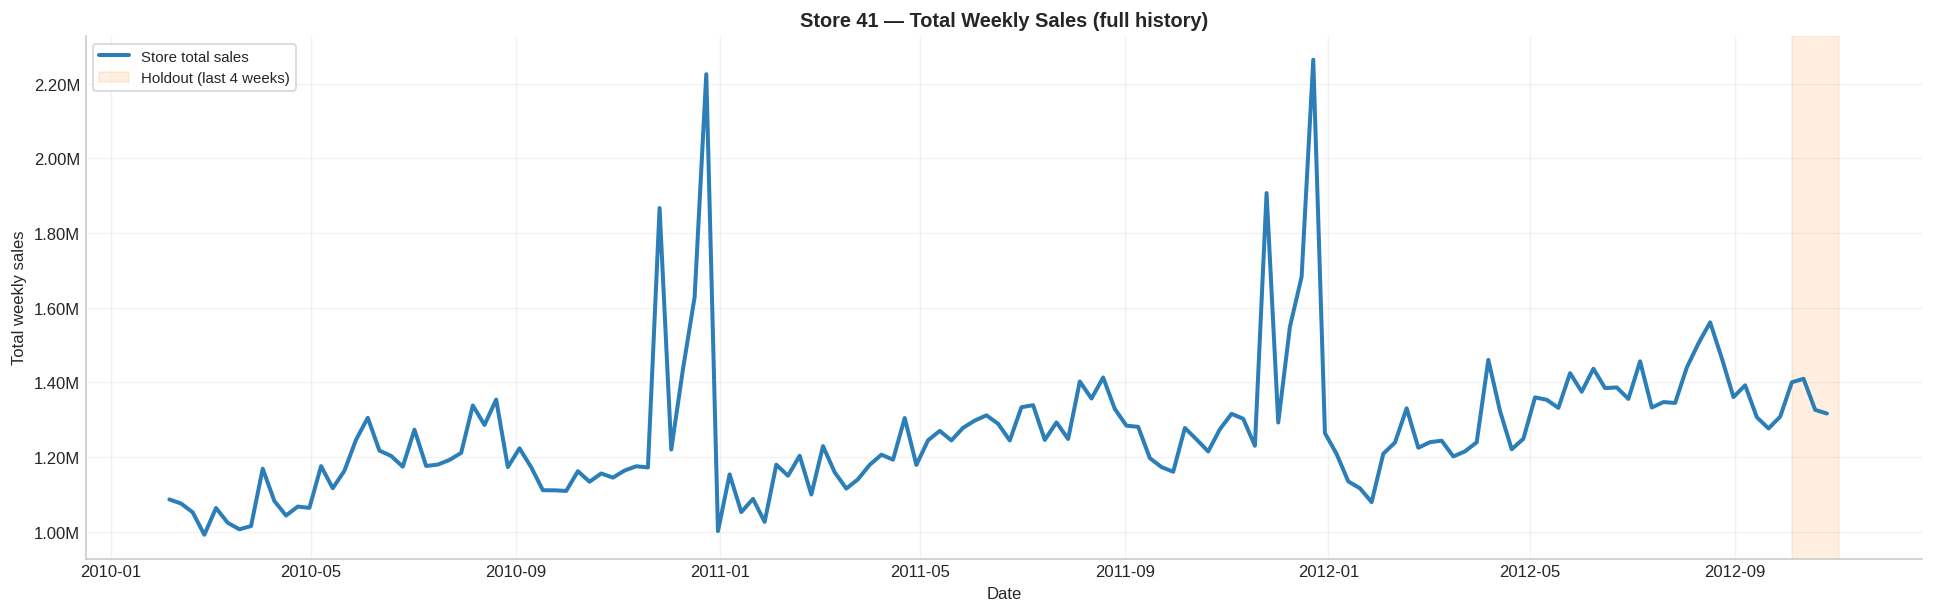

In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
})

def fmt_millions(x, pos):
    return f"{x/1e6:.2f}M"

#Holdout shading (last 4 weeks) 
last_4 = pd.to_datetime(s["Date"].tail(4))
test_start = last_4.min()
test_end = last_4.max() + pd.Timedelta(days=7)

g = s.sort_values("Date").copy()

fig, ax = plt.subplots(figsize=(16, 5), constrained_layout=True)
ax.plot(g["Date"], g["Store_Total_Sales"], linewidth=2.4, alpha=0.95, label="Store total sales")

#holdout window
ax.axvspan(test_start, test_end, alpha=0.12, color="tab:orange", label="Holdout (last 4 weeks)")

ax.set_title(f"Store {STORE_ID} — Total Weekly Sales (full history)")
ax.set_xlabel("Date")
ax.set_ylabel("Total weekly sales")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_millions))
ax.legend(loc="upper left", frameon=True)

plt.show()


## Contract forecasting setup (horizon-2)

In this contract timing:

> * At the beginning of week **w**, we already know actuals through week **w-1**.
> * The forecast we send for **w+2** is therefore **3 steps ahead** from the last known actual.

So the contract forecast is implemented as a **3-step ahead** additive Holt-Winters forecast from the last known point.


In [ ]:
#contract helpers (horizon-2 = 2 weeks ahead from issue week)
#in this contract timing, at the beginning of week w we know actuals through week w-1
#the forecast for week w+2 is therefore 3 steps ahead from the last known point

def hw_additive_forecast_from_state(level, trend, seasonal, n_obs, m, h_steps):
    """
    Multi-step forecast for additive Holt-Winters.
    - n_obs: number of observations already incorporated into the state
    - h_steps: 1 -> forecast for index n_obs (next)
               2 -> forecast for index n_obs+1
               3 -> forecast for index n_obs+2
    """
    idx = (n_obs + (h_steps - 1)) % m
    return level + h_steps * trend + seasonal[idx]

def hw_additive_update_state(level, trend, seasonal, alpha, beta, gamma, y_t, t_index, m):
    """
    One-step state update at absolute time index t_index (0-based).
    """
    idx = t_index % m
    old_level = level
    old_trend = trend
    old_seasonal = seasonal[idx]

    level = alpha * (y_t - old_seasonal) + (1 - alpha) * (old_level + old_trend)
    trend = beta * (level - old_level) + (1 - beta) * old_trend
    seasonal[idx] = gamma * (y_t - level) + (1 - gamma) * old_seasonal

    return level, trend, seasonal

#replace contract_h2_backtest_table to start earlier 
def contract_h2_backtest_table(dates, y, alpha, beta, gamma, m):
    dates = pd.to_datetime(pd.Series(dates)).reset_index(drop=True)
    y = np.asarray(y, dtype=float)

    #need enough points to initialize + produce at least one target_idx = issue_idx+2
    if len(y) < (m + 1) + 3:
        raise ValueError(
            f"Need at least (m+1)+3={m+4} points for m={m}. Got {len(y)} points."
        )

    #holt_winters_additive needs at least m+1 points
    init_len = m + 1
    y_init = y[:init_len]

    _, level, trend, seasonal = holt_winters_additive(y_init, alpha, beta, gamma, m)

    rows = []

    #t_known = last known actual index
    #issue_idx = t_known + 1
    #target_idx = issue_idx + 2 = t_known + 3
    for t_known in range(init_len - 1, len(y) - 3):
        issue_idx = t_known + 1
        target_idx = t_known + 3

        #3 steps ahead from last known actual
        yhat = hw_additive_forecast_from_state(
            level, trend, seasonal, n_obs=t_known + 1, m=m, h_steps=3
        )
        ytrue = y[target_idx]

        issue_date = dates.iloc[issue_idx]
        target_date = dates.iloc[target_idx]

        #week starts 6 days before Friday so label as Saturday
        week_start_target = target_date - pd.Timedelta(days=6)
        month_id = pd.Period(week_start_target, freq="M")

        rows.append({
            "issue_idx": issue_idx,
            "target_idx": target_idx,
            "issue_date": issue_date,
            "target_date": target_date,
            "y_true": ytrue,
            "yhat": yhat,
            "week_start_target": week_start_target,
            "month_id": month_id
        })

        #update with next observed actual y[t_known+1]
        y_next = y[t_known + 1]
        level, trend, seasonal = hw_additive_update_state(
            level, trend, seasonal, alpha, beta, gamma, y_next, t_index=t_known + 1, m=m
        )

    return pd.DataFrame(rows)



### Contract helper functions explanation

#### Multi-step forecast from TES state

> * Uses the TES state: **level, trend, seasonality**
> * Forecasts **h steps ahead** using additive Holt–Winters logic
> * Uses seasonal period **m = 52**

#### One-step TES state update

> * Updates **level**, **trend**, and one seasonal component after observing an actual
> * Keeps the TES state consistent during rolling backtests

#### Contract backtest table

> * For each issue week, produces the forecast for the **target week (issue + 2)**
> * Stores `issue_date`, `target_date`, `y_true`, `yhat`
> * Assigns `month_id` using the **target week’s week_start**

## Parameter tuning for horizon-2 contract forecasts

We split the chosen store data into:

> * `s_model`: all weeks except the last 4 (used for tuning and backtesting)
> * `s_holdout`: the last 4 weeks (kept as holdout)

We tune **alpha, beta, gamma** using a validation slice and evaluate forecasts using the contract backtest timing (horizon-2).

In [ ]:
#train/val split + parameter tuning for contract horizon-2

M = 52

s_model = s.iloc[:-4].copy().reset_index(drop=True)
s_holdout = s.iloc[-4:].copy().reset_index(drop=True)

print("\nModeling end (excluding last 4 weeks):", s_model["Date"].max())
print("Holdout dates (last 4):")
print(s_holdout["Date"].tolist())

y_all = s_model["Store_Total_Sales"].values.astype(float)
d_all = s_model["Date"].values

VAL_LEN = 8

if len(y_all) < (M + 1) + 3 + VAL_LEN:
    raise ValueError(
        f"Not enough points for m={M}, val_len={VAL_LEN}. Got {len(y_all)} points."
    )

y_fit = y_all[:-VAL_LEN]
d_fit = d_all[:-VAL_LEN]
y_val = y_all[-VAL_LEN:]
d_val = d_all[-VAL_LEN:]

alpha_values = [0.2, 0.4, 0.6, 0.8]
beta_values  = [0.1, 0.3, 0.5]
gamma_values = [0.1, 0.3, 0.5]

best = None
best_mae = np.inf

for a in alpha_values:
    for b in beta_values:
        for g in gamma_values:
            bt = contract_h2_backtest_table(
                dates=np.concatenate([d_fit, d_val]),
                y=np.concatenate([y_fit, y_val]),
                alpha=a, beta=b, gamma=g, m=M
            )

            start_val_idx = len(y_fit)
            bt_val = bt[bt["target_idx"] >= start_val_idx].copy()

            if len(bt_val) == 0:
                continue

            score = mae(bt_val["y_true"].values, bt_val["yhat"].values)

            if score < best_mae:
                best_mae = score
                best = (a, b, g)

if best is None:
    raise RuntimeError("Grid search produced no valid result. Paste the printed bt.head() for one run.")

print("\nBest TES params for contract horizon-2 (by validation MAE):")
print("alpha, beta, gamma =", best, " | val_MAE =", best_mae)



Modeling end (excluding last 4 weeks): 2012-09-28 00:00:00
Holdout dates (last 4):
[Timestamp('2012-10-05 00:00:00'), Timestamp('2012-10-12 00:00:00'), Timestamp('2012-10-19 00:00:00'), Timestamp('2012-10-26 00:00:00')]

Best TES params for contract horizon-2 (by validation MAE):
alpha, beta, gamma = (0.2, 0.1, 0.5)  | val_MAE = 31257.801386333216


#### Output explanation

From the split, `s_model` ends before the last 4 weeks, `s_holdout` contains the final 4 dates

From the grid search result, we keep the (alpha, beta, gamma) combination with the **lowest validation MAE** under the contract timing.

## Baseline strategy (no modification)

We backtest horizon-2 forecasts over time and compute the monthly rebate KPI:

> * For each month, sum weekly forecasts in that month → **F_sum**
> * Sum weekly actuals in that month → **A_sum**
> * Compute: **ρ = (F_sum − A_sum) / A_sum**
> * Qualification depends on the bracket **|ρ| ≤ X**

In [ ]:
#baseline backtest + rho_m + X bracket for last 12 months

alpha_star, beta_star, gamma_star = best

bt_base = contract_h2_backtest_table(
    dates=s_model["Date"].values,
    y=s_model["Store_Total_Sales"].values,
    alpha=alpha_star, beta=beta_star, gamma=gamma_star, m=M
)

print("bt_base rows:", len(bt_base))
print("bt_base issue range:", bt_base["issue_date"].min(), "to", bt_base["issue_date"].max())
print("bt_base target range:", bt_base["target_date"].min(), "to", bt_base["target_date"].max())

months_present = sorted(bt_base["month_id"].astype(str).unique())
print("Unique months in bt_base:", len(months_present))
print("First 15 months:", months_present[:15])
print("Last 15 months:", months_present[-15:])

last_month = bt_base["month_id"].max()
start_month = last_month - 11

bt_year = bt_base[(bt_base["month_id"] >= start_month) & (bt_base["month_id"] <= last_month)].copy()

months_year = sorted(bt_year["month_id"].astype(str).unique())
print("\nUnique months in bt_year:", len(months_year))
print("Months in bt_year:", months_year)

if len(months_year) < 12:
    raise ValueError(
        "bt_year has fewer than 12 months. "
        "Paste the months_year list printed above."
    )

monthly_base = (
    bt_year.groupby("month_id")
    .agg(F_sum=("yhat", "sum"), A_sum=("y_true", "sum"))
    .reset_index()
)

monthly_base["rho"] = (monthly_base["F_sum"] - monthly_base["A_sum"]) / monthly_base["A_sum"].replace(0, np.nan)
monthly_base["abs_rho"] = monthly_base["rho"].abs()

X = np.nanmedian(monthly_base["abs_rho"].values)
monthly_base["qualifies"] = monthly_base["abs_rho"] <= X

print("\nBaseline monthly rebate KPI table (last 12 months):")
print(monthly_base)

print("\nChosen X (median |rho| over last 12 months):", X)
print("Baseline qualifying months:", int(monthly_base["qualifies"].sum()), "out of", len(monthly_base))

y_true_year = bt_year["y_true"].values
y_hat_year  = bt_year["yhat"].values

print("\nBaseline weekly accuracy over last 12 months (horizon-2 targets):")
print("MAE :", mae(y_true_year, y_hat_year))
print("RMSE:", rmse(y_true_year, y_hat_year))
print("WAPE%:", wape(y_true_year, y_hat_year))


bt_base rows: 84
bt_base issue range: 2011-02-11 00:00:00 to 2012-09-14 00:00:00
bt_base target range: 2011-02-25 00:00:00 to 2012-09-28 00:00:00
Unique months in bt_base: 20
First 15 months: ['2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04']
Last 15 months: ['2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09']

Unique months in bt_year: 12
Months in bt_year: ['2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09']

Baseline monthly rebate KPI table (last 12 months):
   month_id         F_sum       A_sum       rho   abs_rho  qualifies
0   2011-10  6.158677e+06  6330105.16 -0.027081  0.027081       True
1   2011-11  5.833520e+06  5731766.83  0.017753  0.017753       True
2   2011-12  7.897

### Choosing the bracket X from the past year

We use the last 12 months available and choose **X** so that:

> * Half the months qualify (**|ρ| ≤ X**)
> * Half the months do not qualify (**|ρ| > X**)

#### Output explanation

> * `X` is computed as the **median** of the last-12-months **|ρ|** values.
> * The baseline qualifies **6 out of 12** months by construction.

## Strategy: rolling bias correction at issue time

We modify the forecasts we send to the supplier using a rolling bias estimate:

> * For each issue time, look at the last **K = 8** past targets that were already known at that time
> * Estimate bias (forecasting above/below actuals)
> * Adjust the new forecast using: **yhat_adj = yhat / (1 + bias)**

This changes the sent forecast values and therefore changes the monthly **ρ** values.


In [ ]:
# strategy: rolling bias correction at issue time

bt_adj = bt_year.copy().sort_values("target_idx").reset_index(drop=True)

K = 8
adj_list = []

for i in range(len(bt_adj)):
    t = int(bt_adj.loc[i, "target_idx"])

    #known actuals go through t-3
    max_known_target = t - 3

    past = bt_base[bt_base["target_idx"] <= max_known_target].copy()
    past = past.sort_values("target_idx").tail(K)

    if len(past) == 0:
        bias = 0.0
    else:
        sum_a = past["y_true"].sum()
        if sum_a == 0:
            bias = 0.0
        else:
            bias = (past["yhat"].sum() - past["y_true"].sum()) / sum_a

    yhat_raw = float(bt_adj.loc[i, "yhat"])
    yhat_new = yhat_raw / (1.0 + bias)

    adj_list.append(yhat_new)

bt_adj["yhat_adj"] = adj_list

monthly_adj = (
    bt_adj.groupby("month_id")
    .agg(F_sum=("yhat_adj", "sum"), A_sum=("y_true", "sum"))
    .reset_index()
)

monthly_adj["rho_adj"] = (monthly_adj["F_sum"] - monthly_adj["A_sum"]) / monthly_adj["A_sum"].replace(0, np.nan)
monthly_adj["abs_rho_adj"] = monthly_adj["rho_adj"].abs()
monthly_adj["qualifies_adj"] = monthly_adj["abs_rho_adj"] <= X

month_compare = monthly_base.merge(
    monthly_adj[["month_id", "rho_adj", "abs_rho_adj", "qualifies_adj"]],
    on="month_id",
    how="inner"
)

print("\nMonth-by-month comparison (baseline vs adjusted):")
print(month_compare)

base_n = int(month_compare["qualifies"].sum())
adj_n  = int(month_compare["qualifies_adj"].sum())

print("\nQualifying months (baseline):", base_n, "out of", len(month_compare))
print("Qualifying months (adjusted):", adj_n, "out of", len(month_compare))
print("Extra rebate months gained:", adj_n - base_n)

yhat_adj_year = bt_adj["yhat_adj"].values

print("\nAdjusted weekly accuracy over last 12 months (horizon-2 targets):")
print("MAE :", mae(y_true_year, yhat_adj_year))
print("RMSE:", rmse(y_true_year, yhat_adj_year))
print("WAPE%:", wape(y_true_year, yhat_adj_year))

print("\nAccuracy change (Adjusted - Baseline):")
print("ΔMAE :", mae(y_true_year, yhat_adj_year) - mae(y_true_year, y_hat_year))
print("ΔRMSE:", rmse(y_true_year, yhat_adj_year) - rmse(y_true_year, y_hat_year))
print("ΔWAPE%:", wape(y_true_year, yhat_adj_year) - wape(y_true_year, y_hat_year))



Month-by-month comparison (baseline vs adjusted):
   month_id         F_sum       A_sum       rho   abs_rho  qualifies  \
0   2011-10  6.158677e+06  6330105.16 -0.027081  0.027081       True   
1   2011-11  5.833520e+06  5731766.83  0.017753  0.017753       True   
2   2011-12  7.897466e+06  7966958.22 -0.008723  0.008723       True   
3   2012-01  4.684293e+06  4539286.93  0.031945  0.031945      False   
4   2012-02  4.626913e+06  5034024.94 -0.080872  0.080872      False   
5   2012-03  6.071501e+06  6360338.27 -0.045412  0.045412      False   
6   2012-04  5.259639e+06  5152541.44  0.020785  0.020785       True   
7   2012-05  5.697016e+06  5484191.37  0.038807  0.038807      False   
8   2012-06  7.236429e+06  7019276.50  0.030937  0.030937      False   
9   2012-07  5.717191e+06  5464101.32  0.046319  0.046319      False   
10  2012-08  5.745771e+06  5890116.36 -0.024506  0.024506       True   
11  2012-09  5.242938e+06  5283325.44 -0.007644  0.007644       True   

     rho_adj

### Baseline vs adjusted results

#### Output explanation

> * We compare qualifying months under the **same X** threshold.
> * The adjusted strategy increases the number of qualifying months if it moves more months inside **|ρ| ≤ X**.


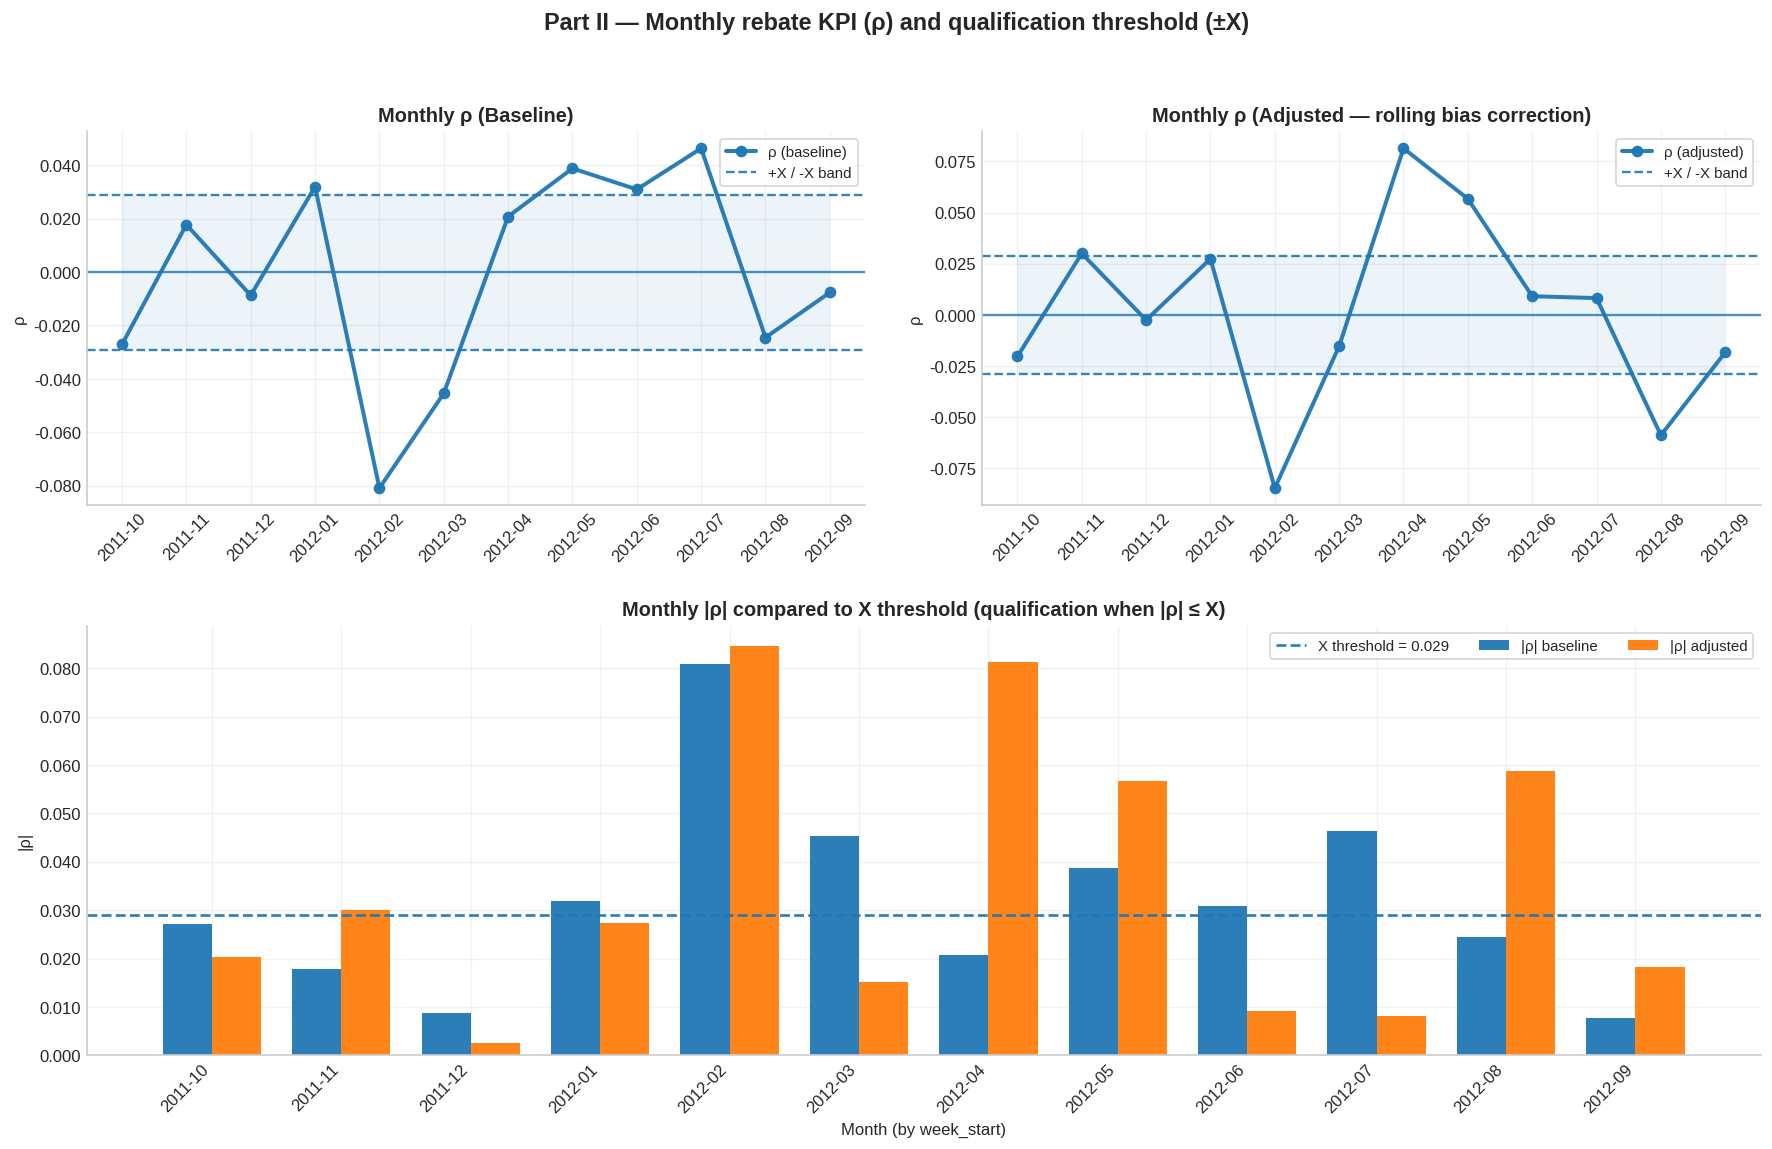

In [ ]:
#Reporting plots (rho baseline vs adjusted + |rho| vs X)
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.25,
})

#ordering by month 
mc = month_compare.sort_values("month_id").copy()
labels = mc["month_id"].astype(str).tolist()
x = np.arange(len(labels))

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 1.15], hspace=0.30, wspace=0.15)

ax1 = fig.add_subplot(gs[0, 0])   
ax2 = fig.add_subplot(gs[0, 1])   
ax3 = fig.add_subplot(gs[1, :])   

fig.suptitle("Part II — Monthly rebate KPI (ρ) and qualification threshold (±X)", fontsize=14, fontweight="bold", y=0.98)

#baseline rho
ax1.plot(labels, mc["rho"].values, marker="o", linewidth=2.4, alpha=0.95, label="ρ (baseline)")
ax1.axhline(0, linewidth=1.4, alpha=0.8)

#acceptable band [-X, +X] for readability
ax1.axhline(+X, linestyle="--", linewidth=1.4, alpha=0.9, label="+X / -X band")
ax1.axhline(-X, linestyle="--", linewidth=1.4, alpha=0.9)
ax1.fill_between(labels, -X, +X, alpha=0.08)

ax1.set_title("Monthly ρ (Baseline)")
ax1.set_xlabel("")
ax1.set_ylabel("ρ")
ax1.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
ax1.tick_params(axis="x", rotation=45)
ax1.legend(loc="upper right", frameon=True)

#adjusted rho
ax2.plot(labels, mc["rho_adj"].values, marker="o", linewidth=2.4, alpha=0.95, label="ρ (adjusted)")
ax2.axhline(0, linewidth=1.4, alpha=0.8)
ax2.axhline(+X, linestyle="--", linewidth=1.4, alpha=0.9, label="+X / -X band")
ax2.axhline(-X, linestyle="--", linewidth=1.4, alpha=0.9)
ax2.fill_between(labels, -X, +X, alpha=0.08)

ax2.set_title("Monthly ρ (Adjusted — rolling bias correction)")
ax2.set_xlabel("")
ax2.set_ylabel("ρ")
ax2.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
ax2.tick_params(axis="x", rotation=45)
ax2.legend(loc="upper right", frameon=True)

# |rho| vs X bars (baseline vs adjusted)
width = 0.38
ax3.bar(x - width/2, mc["abs_rho"].values, width=width, label="|ρ| baseline", alpha=0.95)
ax3.bar(x + width/2, mc["abs_rho_adj"].values, width=width, label="|ρ| adjusted", alpha=0.95)
ax3.axhline(X, linestyle="--", linewidth=1.6, alpha=0.95, label=f"X threshold = {X:.3f}")

ax3.set_title("Monthly |ρ| compared to X threshold (qualification when |ρ| ≤ X)")
ax3.set_xlabel("Month (by week_start)")
ax3.set_ylabel("|ρ|")
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45, ha="right")
ax3.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
ax3.legend(loc="upper right", ncol=3, frameon=True)

plt.show()


## Conclusion of Part II

Let's go through everything that we performed. In Part II we worked only with **store-total weekly sales**, because the contract is defined at store level.

We built the weekly store-total series and confirmed the calendar is consistent (**all weeks are 7 days apart** and dates are always **Fridays**). Then we selected a store with strong yearly seasonality using the **lag-52 correlation**. With this rule, the best store was **Store 41** (lag-52 corr ≈ **0.95**) and it has **143 weeks** of data.

### Forecasting setup (contract horizon-2)

The contract requires a forecast **two weeks ahead**, so for each issue week we produced a **horizon-2** forecast using **additive Holt–Winters** (m = 52). We tuned (α, β, γ) using validation MAE and got:

* Best parameters: **(α, β, γ) = (0.2, 0.1, 0.5)**  
* Validation MAE (contract horizon-2): **31257.80**

### Rebate KPI and baseline qualification

For the last **12 months** (2011-10 to 2012-09), we computed the monthly rebate KPI:

* Monthly **ρₘ = (F_sum − A_sum) / A_sum**
* We set **X = median(|ρₘ|)** over the last 12 months, so that **half the months qualify** by design.

Baseline results:

* **X = 0.0290**
* Baseline qualifying months: **6 out of 12**
* Baseline weekly accuracy (last 12 months, horizon-2):
  * **MAE = 55273.52**
  * **RMSE = 69593.14**
  * **WAPE = 4.09%**

So the baseline already gives a reasonable weekly error (~4% WAPE), but only **6/12 months** stay inside the ±X contract band.

### Strategy: rolling bias correction (maximize qualifying months)

To increase rebate chances, we applied a **rolling bias correction** using the most recent **K = 8** known target weeks. This changes the forecasts to reduce systematic over/under-shoot at issue time.

Adjusted results:

* Qualifying months (adjusted): **7 out of 12**  → **+1 extra month**
* Adjusted weekly accuracy (last 12 months, horizon-2):
  * **MAE = 60575.35**
  * **RMSE = 76301.08**
  * **WAPE = 4.48%**

Accuracy trade-off (Adjusted − Baseline):

* **ΔMAE = +5301.83**
* **ΔRMSE = +6707.94**
* **ΔWAPE = +0.39%**

So the strategy **improved the contract outcome** (more qualifying months), but it also **reduced point-forecast accuracy**. So we are optimizing for **contract qualification (|ρₘ| ≤ X)**, not only for lowest forecast error.
